In [1]:
# !pip install pandas
# !pip install numpy
# !pip install tensorflow
# !pip install setuptools
# !pip install keras
# !pip install keras-tuner
# !pip install seaborn
# !pip install matplotlib
# !pip install scikit-learn
# !pip install scipy
# !pip install statsmodels
# !pip install pvlib
# !pip install xgboost
# !pip install ipython

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization, Conv1D, MaxPooling1D, Reshape, GRU, Bidirectional
from keras.layers import MultiHeadAttention, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from keras.losses import  MeanSquaredError, MeanAbsoluteError, MeanSquaredLogarithmicError

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from IPython.display import display
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_log_error, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

import matplotlib.pyplot as plt
import os

import pvlib

### Методи

In [3]:
# Довжину вхідної послідовності для LSTM
sequence_length = 4

# Кількість часових кроків на виході LSTM
forecast_steps = 1

In [4]:
# Отримання даних по станції за період
def get_data(_station_name, _power_max, _date_start, _date_end, _meteo_source = 'OpenMeteo', _actual_source = 'Nordik'):

    # Завантаження даних
    df_meteo = pd.read_csv(f'../data/{_station_name}_{_meteo_source}_Data.csv', sep=',', comment='#')
    df_meteo['datetime'] = pd.to_datetime(df_meteo['datetime'], format='mixed', utc=True)

    actual_parameters=['datetime', 'power', 'limitation']
    df_actual = pd.read_csv(f'../data/{_station_name}_{_actual_source}_Data.csv', sep=',', comment='#', usecols=actual_parameters)
    df_actual['datetime'] = pd.to_datetime(df_actual['datetime'], format='mixed', utc=True)

    # Злиття датафреймів
    data_input = pd.DataFrame()
    data_input = pd.merge(df_actual, df_meteo, on='datetime', how='outer', suffixes=('_actual', '_predict'))

    # Перевірка на однакові колонки
    for col in df_actual.columns:
        if col in df_meteo.columns and col not in ['datetime']:
            # Якщо є однакові колонки то залишити з df_actual 
            data_input[col] = data_input[f"{col}_actual"].combine_first(data_input[f"{col}_predict"])
            data_input.drop(columns=[f"{col}_predict", f"{col}_actual"], inplace=True)

    # Збереження необхідних колонок
    data_input.columns = [col.replace('_actual', '') for col in data_input.columns]
    data_input = data_input[df_actual.columns.tolist() + [col for col in df_meteo.columns if col not in df_actual.columns and col != 'datetime']]

    add_time_transofrm(data_input, _tranform_hours = True, _transform_days = True)
    data_input.set_index('datetime', inplace=True)

    # Фільтрація даних за датою
    if _date_start is not None and _date_end is not None:
        _data = data_input.loc[_date_start:_date_end].copy()
    elif _date_start is not None:
        _data = data_input.loc[_date_start:].copy()
    elif _date_end is not None:
        _data = data_input.loc[:_date_end].copy()
    else:
        _data = data_input.copy()

    # Видалення невалідних записів
    if 'limitation' in _data.columns:
        _data = _data[_data['limitation'] == 0]
        _data.drop(columns=['limitation'], inplace=True)
    
    # Видалення пропущених значень
    _data.dropna(inplace=True)
    
    # Обмеження значень потужності
    _data.clip(lower=0, upper=_power_max, inplace=True)

    return _data

In [5]:
# Представлення кодів погоди у вагових коефіцієнтах
def add_weather_codes(data):
    
    # Мапінг кодів у вагові коефіцієнти
    weather_code_mapping = {
        
        # Мінімальний вплив
        0: 0.2,

        # Середній вплив
        1: 0.5, 2: 0.5, 3: 0.5,
        51: 0.5, 53: 0.5, 55: 0.5,
        
        # Сильний вплив
        45: 0.8, 48: 0.8,
        56: 0.8, 57: 0.8,
        
        # Критичний вплив
        61: 1.0, 63: 1.0, 65: 1.0,
        66: 1.0, 67: 1.0,
        71: 1.0, 73: 1.0, 75: 1.0,
        77: 1.0,
        80: 1.0, 81: 1.0, 82: 1.0,
        85: 1.0, 86: 1.0,
        95: 1.0,
        96: 1.0, 99: 1.0
    }

    weather_code_column = 'weather_code'
    if weather_code_column in data.columns:
        data['weather_conditions'] = data[weather_code_column].map(weather_code_mapping)
        data.drop(columns=[weather_code_column], inplace=True)

    return data

In [6]:
def add_solarposition(_data, _latitude, _longitude, _altitude=350):

    # Отримуємо сонячну позицію для всіх рядків
    solar_positions = pvlib.solarposition.get_solarposition(
        time=_data.index,
        latitude=_latitude,
        longitude=_longitude,
        altitude=_altitude
    )
    # https://pvlib-python.readthedocs.io/en/v0.4.2/api.html
    
    _data['apparent_elevation'] = solar_positions['apparent_elevation'].clip(lower=0)
    _data['solar_azimuth'] = solar_positions['azimuth']
    _data['is_night'] = _data['apparent_elevation'] <= 0
    
    return _data

In [7]:
def add_forecast_0(_data, columns_list = ['gti', 'ghi', 'dni']):

    # Перевірка на порожній DataFrame
    if _data.empty:
        print("Вхідний DataFrame _data порожній.")
        return _data
    
    # Вибірка даних
    columns = [col for col in columns_list if col in _data.columns]
    
    if not columns:
        print("Жодна з колонок у columns_list не знайдена в _data.")
        return _data
    
    X = _data[columns]
    if X.empty:
        print("Відфільтрований DataFrame X порожній.")
        return _data
    
    if 'power' not in _data.columns:
        print("Колонка 'power' відсутня в _data.")
        return _data
    
    y = _data['power']

    reg = LinearRegression()
    reg.fit(X, y)

    # Прогнозування
    y_pred = reg.predict(X)
    _data['forecast_0'] = y_pred
    _data.loc[:, 'forecast_0'] = _data['forecast_0'].clip(lower=0)

    return _data

In [8]:
# Cинусоїдальні та косинусоїдальні перетворення часу для моделювання циклічності часу (доба і рік)
def add_time_transofrm(_data, _tranform_hours = True, _transform_days = True):

    # Трансформація годин
    if _tranform_hours:
        _data["minute"] = _data["datetime"].dt.minute
        _data["hour"] = _data["datetime"].dt.hour
        _data["total_minutes"] = _data["hour"] * 60 + _data["minute"]
    
        peak_shift = 780 + 3 * 60
        _data["adjusted_minutes"] = (
            _data["total_minutes"] - peak_shift) % 1440

        # Застосування синусоїдальних і косинусоїдальних перетворень до годин
        _data["hour_sin"] = np.sin(
            2 * np.pi * _data["adjusted_minutes"] / 1440)
        _data["hour_cos"] = np.cos(
            2 * np.pi * _data["adjusted_minutes"] / 1440)
        
        _data.drop(columns=["minute","hour","total_minutes","adjusted_minutes"],errors="ignore",inplace=True,)

    # Трансформація дня року
    if _transform_days:
        _data["day"] = _data["datetime"].dt.dayofyear
        peak_shift_day = 173

        _data["adjusted_day"] = (_data["day"] - peak_shift_day) % 365

        # Застосування синусоїдальних і косинусоїдальних перетворень до днів року
        _data["day_sin"] = np.sin(2 * np.pi * _data["adjusted_day"] / 365)
        _data['day_cos'] = np.cos(
            2 * np.pi * _data['adjusted_day'] / 365 / 2.)

        _data.drop(columns=["day","adjusted_day",],errors="ignore",inplace=True,)

In [9]:
# Додавання лагів для вибраних ознак
def add_lag_features(_data, lagged_features, lags):
    
    new_features = lagged_features.copy()

    for feature in lagged_features:
        for lag in range(1, lags + 1):
            lag_col = f'{feature}_lag_{lag}'
            _data[lag_col] = _data[feature].shift(lag)
            new_features.append(lag_col)

    # Видалення рядків з порожніми значеннями після додавання лагів
    _data.dropna(subset=new_features, inplace=True)
    return _data

In [10]:
# Додаткові ознаки
def add_features(_data, _latitude, _longitude, _altitude, _meteo_source):

    # Розрахунок висоти сонця
    add_solarposition(_data, _latitude, _longitude, _altitude)

    # Обробка кодів погоди
    add_weather_codes(_data)

    # Розрахунок прогнозної потужності Linear Regression
    meteo_parameters_dict = {
        'Nordik': ['ghi', 'temperature_pv'],
        'Copernicus': ['toa', 'ghi', 'bhi', 'dhi', 'bni'],
        'OpenMeteo': ['gti', 'ghi', 'dni'],
    }
    meteo_parameters = meteo_parameters_dict.get(_meteo_source, ['ghi'])
    add_forecast_0(_data, columns_list=meteo_parameters)

    add_lag_features(_data, meteo_parameters, 3)

    return _data

In [11]:
# Підготовка даних для моделі
def prepare_data(_data, _scaler, _power_max, _split_ratio=0.8, use_all_features = False):

    # Вибрані ознаки
    if use_all_features:
        feature_columns = [col for col in _data.columns if col != "power"]
    else:
        feature_columns = ['forecast_0', 'gti', 'temperature_air', 'temperature_pv', 'humidity', 'apparent_elevation', 'is_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']
        feature_columns += [col for col in _data.columns if '_lag_' in col]
    feature_columns = [col for col in feature_columns if col in _data.columns]

    # Цільова змінна
    target_column = 'power'    

    # Вибірка даних для моделі
    # Перша колонка - цільова змінна power, інші - ознаки
    _data = _data[[target_column] + feature_columns]

    # Розділення даних на навчальну та тестову вибірки
    if _split_ratio != 0:
        split_index = int(len(_data) * _split_ratio)
        data_train = _data.iloc[:split_index]
        data_test = _data.iloc[split_index:]
    else:
        data_train = _data
        data_test = _data

    # Масштабування даних
    data_train_scaled = _scaler.fit_transform(data_train)
    data_test_scaled = _scaler.transform(data_test)

    def prepare_sequences(scaled_data, original_data, sequence_length, forecast_steps):
        X, y, datetimes = [], [], []
        for i in range(sequence_length, len(scaled_data) - forecast_steps + 1):
            y.append(scaled_data[i:i+forecast_steps, 0])    # цільова змінна power
            X.append(scaled_data[i-sequence_length:i, 1:])  # ознаки
            datetimes.append(original_data.index[i+forecast_steps-1])
        return np.array(X), np.array(y), datetimes

    X_train, y_train, datetimes_train = prepare_sequences(data_train_scaled, data_train, sequence_length, forecast_steps)

    X_test, y_test, datetimes_test = prepare_sequences(data_test_scaled, data_test, sequence_length, forecast_steps)

    print(f"\nРозмір навчальної вибірки: {len(X_train)}")
    print(f"Розмір тестової вибірки: {len(X_test)}")
    print(f"Ознаки ({len(feature_columns)}): {feature_columns}")

    return X_train, X_test, y_train, y_test, datetimes_train, datetimes_test

In [12]:
def restore_data(_scaler, _forecast, _X_test, _y_test, _datetimes_test):

    # Визначення кількості колонок у масштабованих даних
    n_features = _scaler.n_features_in_

    # Перевірка узгодженості розмірів
    if len(_forecast) != len(_y_test) or len(_datetimes_test) != len(_forecast):
        raise ValueError("Розміри _forecast, _y_test і _datetimes_test не збігаються.")

    # Відновлення масштабу для тестових даних
    y_test_rescaled = _scaler.inverse_transform(
        np.c_[_y_test[:, 0], np.zeros((_y_test.shape[0], n_features - 1))]
    )[:, 0]

    # Відновлення масштабу для прогнозу
    forecast_rescaled = _scaler.inverse_transform(
        np.c_[_forecast[:, 0], np.zeros((_forecast.shape[0], n_features - 1))]
    )[:, 0]

    # Створення DataFrame з відновленими даними
    data_forecast = pd.DataFrame({
        "datetime": _datetimes_test,
        "power": y_test_rescaled,
        "forecast": forecast_rescaled
    })

    # Сортування за датою (необов'язково, якщо дані вже впорядковані)
    data_forecast.sort_values('datetime', inplace=True)

    return data_forecast


In [13]:
def correct_forecast(_data_forecast, _data):
    
    _data_forecast.loc[:, 'forecast'] = _data_forecast['forecast'].clip(lower=0)

    _data_forecast = _data_forecast.merge(_data, on='datetime', how='left', suffixes=('', '_train'))

    if 'forecast_0' in _data_forecast.columns and 'is_night' in _data_forecast.columns:
        _data_forecast.loc[(_data_forecast['forecast_0'] == 0) | (_data_forecast['is_night'] == 1), 'forecast'] = 0

    return _data_forecast

In [14]:
# Графік відносних залишків
def plot_residuals(_y_train_actual=None, _y_train_forecast=None, _y_test_actual=None, _y_test_forecast=None, _power_max=0, _title="Графік відносних залишків"):

    plt.figure(figsize=(8, 4))

    # Автоматичне визначення power_max, якщо він не заданий
    if _power_max == 0:
        max_train = max(_y_train_actual) if _y_train_actual is not None else 0
        max_test = max(_y_test_actual) if _y_test_actual is not None else 0
        _power_max = max(max_train, max_test)
        _power_max = max(_power_max, 1)
        
    # Перевірка та побудова графіка для навчальних даних
    if _y_train_actual is not None and _y_train_forecast is not None:
        train_residuals = (_y_train_actual - _y_train_forecast) / _power_max
        plt.scatter(_y_train_forecast, train_residuals, alpha=0.5, color='#87CEEB', marker='o', label='Навчальні дані')

    # Перевірка та побудова графіка для тестових даних
    if _y_test_actual is not None and _y_test_forecast is not None:
        test_residuals = (_y_test_actual - _y_test_forecast) / _power_max
        plt.scatter(_y_test_forecast, test_residuals, alpha=0.5, color='#FFD700', marker='s', label='Тестові дані')

    # Лінія нульових залишків
    plt.axhline(0, color='black', linewidth=2, linestyle='--', label='Лінія 0 залишків')

    plt.xlabel('Прогнози, кВт')
    plt.ylabel('Відносні залишки')
    plt.title(_title)
    plt.legend(loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [15]:
def plot_residual_histogram(_y_actual, _y_forecast, _bins=30, _power_max=0, _title="Гістограма залишків"):

    # Автоматичне визначення power_max, якщо він не заданий
    if _power_max == 0:
        max_train = max(_y_actual) if _y_actual is not None else 0
        _power_max = max(max_train, 1)

    # Розрахунок залишків
    residuals = ( _y_actual - _y_forecast ) / _power_max

    plt.figure(figsize=(8, 4))
    plt.hist(residuals, bins=_bins, edgecolor='black', alpha=0.7, color='skyblue')
    plt.title(_title)
    plt.xlabel("Залишки")
    plt.ylabel("Частота")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [16]:
# Відображення кривих навчання
def plot_loss(_history, _title='Криві навчання', _metrics=['loss']):

    for metric in _metrics:
        plt.figure(figsize=(5, 3))
        plt.plot(_history.history[metric], label=f'{metric} на тренуванні')
        plt.plot(_history.history[f'val_{metric}'], label=f'{metric} на перевірці')
        plt.xlabel('епохи')
        plt.ylabel(metric)
        plt.title(f'{_title} - {metric}')
        plt.legend()
        plt.grid(True)
        plt.show()

In [17]:
# Відображення часових рядів
def plot_series(_data, _columns, _title="Фактична і Прогнозована потужність", _metrics=None, _split_days=0):

    # Дата-час може бути в індексі або в колонці "datetime"
    if "datetime" in _data.columns:
        datetime_col = _data["datetime"]
    else:
        datetime_col = _data.index

    start_index = 0
    end_index = len(_data)
    data_plot = _data.iloc[start_index:end_index].copy()
    datetime_col_plot = datetime_col[start_index:end_index]

    # Візуалізація графіків
    plt.figure(figsize=(15, 5))
    for col in _columns:
        plt.plot(datetime_col_plot, data_plot[col["column"]], label=col["label"])
    plt.title(f"{_title}")
    
    # Візуалізація метрик
    metrics_text = ""
    if _metrics is not None:
        metrics_text = "\n".join([
            f'MAE = {_metrics["MAE"]:.1f}',
            f'MAPE(max) = {_metrics["MAPE(max)"]:.1f}%',
            f'MSE = {_metrics["MSE"]:.1f}',            
            f'RMSE = {_metrics["RMSE"]:.1f}',
            f'RMSE(max) = {_metrics["RMSE(max)"]:.1f}%',
            f'R2 = {_metrics["R2"]:.3f}',
            f'Bias = {_metrics["Bias"]:.1f}',            
            f'MSLE = {_metrics["MSLE"]:.3f}',
        ])
        
    plt.legend(loc='upper left', title=metrics_text)
    
    plt.grid(True)
    plt.show()

    # Візуалізація графіків по частинах
    if _split_days > 0:
        data_len = len(_data)
        days_in_step = _split_days * 24 * 4
        for i in range(0, data_len, days_in_step):
            data_chunk = _data.iloc[i:i + days_in_step]
            datetime_chunk = datetime_col.iloc[i:i + days_in_step]

            plt.figure(figsize=(15, 5))
            for col in _columns:
                plt.plot(datetime_chunk, data_chunk[col["column"]], label=col["label"])
            plt.title(f"{_title} - Інтервал {i // days_in_step + 1}")
            plt.legend(loc='upper left')
            plt.grid(True)
            plt.show()


In [18]:
# Завантаження моделі з файлу
def get_model(_model_name):
    
    model = load_model(f"../temp/{_model_name}.keras")
    scaler = np.load(f"../temp/{_model_name}.npy", allow_pickle=True).item()
    
    return model, scaler

In [34]:
# Побудова моделі
def create_model(X_train):

    # # Побудова моделі
    # layer_params = [
    #     {
    #         "units": 192,
    #         "activation": "elu",
    #         "dropout": 0.05,
    #         "regularizer": l2(0.01)
    #     },
    #     {
    #         "units": 1024,
    #         "activation": "relu",
    #         "dropout": 0.05,
    #         "regularizer": l2(0.01)
    #     },
    #     {
    #         "units": 128,
    #         "activation": "selu",
    #         "dropout": 0.1,
    #         "regularizer": l2(0.01)
    #     },
    #     {
    #         "units": 96,
    #         "activation": "elu",
    #         "dropout": 0.1,
    #         "regularizer": l2(0.01)
    #     },        
    # ]
    # model_lstm = Sequential([
    #     Input(shape=(X_train.shape[1], X_train.shape[2])),
    #     LSTM(
    #         units=layer_params[0]["units"],
    #         activation=layer_params[0]["activation"],
    #         return_sequences=True,
    #         kernel_regularizer=layer_params[0]["regularizer"],
    #     ),
    #     Dropout(layer_params[0]["dropout"]),
    #     BatchNormalization(),
    #     LSTM(
    #         units=layer_params[1]["units"],
    #         activation=layer_params[1]["activation"],
    #         return_sequences=True,
    #         kernel_regularizer=layer_params[1]["regularizer"],
    #     ),
    #     Dropout(layer_params[1]["dropout"]),
    #     BatchNormalization(),
    #     LSTM(
    #         units=layer_params[2]["units"],
    #         activation=layer_params[2]["activation"],
    #         return_sequences=True,
    #         kernel_regularizer=layer_params[2]["regularizer"],
    #     ),
    #     Dropout(layer_params[2]["dropout"]),
    #     BatchNormalization(), 
    #     LSTM(
    #         units=layer_params[3]["units"],
    #         activation=layer_params[3]["activation"],
    #         return_sequences=False,
    #         kernel_regularizer=layer_params[3]["regularizer"],
    #     ),

    #     Dense(forecast_steps, activation='selu')
    # ])
    # # Компіляція моделі
    # model_lstm.compile(optimizer='nadam', loss=['mse'])
    # # MeanSquaredLogarithmicError, MeanSquaredError, MeanAbsoluteError

    # return model_lstm



    model_lstm = Sequential([
        Input(shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(
            units=128,
            activation='relu',
            return_sequences=True,
        ),
        Dropout(0.1),
        BatchNormalization(),
        LSTM(
            units=256,
            activation='relu',
            return_sequences=True,
        ),
        Dropout(0.1),
        BatchNormalization(),
        LSTM(
            units=128,
            activation='relu',
            return_sequences=True,
        ),
        LSTM(50, return_sequences=False),
        Dense(forecast_steps, activation='linear')
    ])
    model_lstm.compile(optimizer='adam', loss='mse')  
    return model_lstm



    # model_cnn_lstm = Sequential([

    #     Input(shape=(X_train.shape[1], X_train.shape[2])),
        
    #     # CNN блок
    #     Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),  # Додано padding='same'
    #     Dropout(0.2),
        
    #     # Другий CNN блок
    #     # relu - Нелінійна активація для витягування складних ознак.
    #     # padding='same': Забезпечує, що вихід має ту саму довжину, що й вхід.
    #     Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    #     Dropout(0.2), # Вимикає 20% нейронів під час навчання для уникнення перенавчання.
        
    #     # -1 визначає розмір автоматично, 64 — кількість фільтрів з CNN
    #     # Перетворює тривимірний вихід CNN (час, фільтри) у формат для LSTM
    #     Reshape((-1, 64)),  
        
    #     # LSTM блок
    #     LSTM(50, return_sequences=True),
    #     Dropout(0.1),
    #     LSTM(50, return_sequences=True),
    #     Dropout(0.1),

    #     # return_sequences=False: Повертає лише останній стан (вихід для останнього кроку часу).
    #     LSTM(50, return_sequences=False),
    #     Dropout(0.1),
        
    #     # Fully Connected Layers
    #     # Використовується для об’єднання витягнутих ознак у менший набір
    #     Dense(25, activation='relu'),
    #     # Генерує кінцевий прогноз на основі заданої кількості кроків
    #     Dense(forecast_steps)
    # ])

    # # Компіляція моделі
    # # Оптимізатор Nadam (Nesterov-accelerated Adam), ефективний для роботи з нерівномірними градієнтами.
    # # Функція втрат: середньоквадратична похибка (MSE), чутлива до великих відхилень у прогнозах.
    # model_cnn_lstm.compile(optimizer='nadam', loss='mse')

    # return model_cnn_lstm



    # model_cnn_gru = Sequential([
    #     Input(shape=(X_train.shape[1], X_train.shape[2])),
        
    #     # CNN блок
    #     Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),  # Додано padding='same'
    #     MaxPooling1D(pool_size=2, padding='same'),  # Щоб уникнути зменшення розміру до негативного
    #     GRU(50, return_sequences=True),
    #     Dropout(0.1),
    #     GRU(50, return_sequences=False),
    #     Dense(forecast_steps)
    # ])

    # # Компіляція моделі
    # model_cnn_gru.compile(optimizer='nadam', loss='mse')
    # return model_cnn_gru


    # inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # # CNN частина
    # x = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    # x = MaxPooling1D(pool_size=2)(x)

    # # Transformer частина
    # # Для MultiHeadAttention потрібні query, key і value
    # attn_output = MultiHeadAttention(num_heads=4, key_dim=64)(x, x)
    # x = Flatten()(attn_output)

    # # Повнозв'язний шар
    # x = Dense(25, activation='relu')(x)
    # outputs = Dense(1)(x)

    # # Модель
    # model_cnn_tranformers = Model(inputs=inputs, outputs=outputs)

    # # Компіляція моделі
    # model_cnn_tranformers.compile(optimizer='nadam', loss='mse')

    # return model_cnn_tranformers



In [35]:
# Збереження моделі в файлі
def save_model(_model, _scaler, _model_name):

    path = "../temp/"
    os.makedirs(path, exist_ok=True)

    _model.save(f"{path}{_model_name}.keras")
    np.save(f"../temp/{_model_name}.npy", _scaler)

In [36]:
# Тренування моделі
def do_train(_model, _X_train, _X_test, y_train, y_test):

    history = _model.fit(
        _X_train, y_train,
        validation_data=(_X_test, y_test),
        epochs=32,
        batch_size=64,
        callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        verbose=1
    )
    return history

In [37]:
# Розрахунок метрик
def evaluate_data(_forecast, _actual, _power_max=0, _print_metrics=False):

        if _power_max == 0:
            _power_max = np.max(_actual)

        tae = np.sum(np.abs(_forecast - _actual))

        mae = mean_absolute_error(_actual, _forecast)
        mae_max = (mae / _power_max) * 100

        ape_koef = 0.1
        mask = _actual > ape_koef * _power_max
        if np.any(mask):
            ape_filtered = np.mean(np.abs((_forecast[mask] - _actual[mask]) / _actual[mask])) * 100
        else:
            ape_filtered = np.nan

        mape = mean_absolute_percentage_error(_actual, _forecast) * 100
        mape_max = np.mean(np.abs((_forecast - _actual) / _power_max)) * 100  

        def symmetric_mean_absolute_percentage_error(actual, forecast):
            numerator = np.abs(actual - forecast)
            denominator = (np.abs(actual) + np.abs(forecast)) / 2
            smape = np.mean(numerator / denominator) * 100
            return smape
        smape = symmetric_mean_absolute_percentage_error(_actual, _forecast)

        mse = mean_squared_error(_actual, _forecast)

        rmse = np.sqrt(mse)
        rmse_max = np.sqrt(mse) / _power_max * 100

        r2 = r2_score(_actual, _forecast)
        ev = explained_variance_score(_actual, _forecast)

        bias = np.mean(_forecast - _actual) / _power_max * 100

        msle = mean_squared_log_error(_actual - np.min(_actual) + 1,
                                      _forecast - np.min(_forecast) + 1)
        try:
            pcc, _ = pearsonr(_actual - np.min(_actual) + 1,
                              _forecast - np.min(_forecast) + 1)
        except ValueError: pcc = np.nan

        metrics = {
            "TAE": tae,
            "MAE": mae,
            "MSE": mse,
            "R2": r2,
            "MSLE": msle,
            "Bias": bias,
            "APE": ape_filtered,
            "MAPE": mape,
            "MAPE(max)": mape_max,
            "sMAPE": smape,
            "RMSE": rmse,
            "RMSE(max)": rmse_max,
            "EV": ev,
            "PCC": pcc
        }

        if _print_metrics:
            for key, value in metrics.items():
                print(f"{key}: {value:.3f}")

        return metrics

In [38]:
# Прогнозування
def do_forecast(_model, _X, batch_size=None, verbose=0):

    try:
        # Перевірка моделі та даних
        if _model is None or not hasattr(_model, 'predict'):
            raise ValueError("Передана модель не має методу 'predict' або не задана.")
        if _X is None or not isinstance(_X, np.ndarray):
            raise ValueError("Передані вхідні дані повинні бути масивом numpy (np.ndarray).")

        # Прогнозування
        forecast = _model.predict(_X, batch_size=batch_size, verbose=verbose)
        return forecast

    except Exception as e:
        print(f"Помилка під час прогнозування: {e}")
        return None

## Навчання та прогнозування

In [39]:
model_name = 'lstm_model'

models_list = [
    {
        "station_name": 'Yavoriv',
        "meteo_source": 'OpenMeteo',
        "power_max": 59234,
        "latitude": 49.935239,
        "longitude": 23.505527,
        "altitude": 270,
        "date_train_start": '2024-04-02',
        "date_train_end": '2024-09-15'
    },
    {
        "station_name": 'Glyniany-1',
        "meteo_source": 'OpenMeteo',
        "power_max": 2976,
        "latitude": 49.826009,
        "longitude": 24.476087,
        "altitude": 310,
        "date_train_start": '2024-04-02',
        "date_train_end": '2024-09-15'
    },
    {
        "station_name": 'Glyniany-2',
        "meteo_source": 'OpenMeteo',
        "power_max": 15442,
        "latitude": 49.826411,
        "longitude": 24.488083,
        "altitude": 310,
        "altitude": 350,
        "date_train_start": '2024-04-02',
        "date_train_end": '2024-09-15'
    },
    {
        "station_name": 'Boryslav',
        "meteo_source": 'OpenMeteo',
        "power_max": 7153,
        "latitude": 49.308290,
        "longitude": 23.430082,
        "altitude": 350,
        "date_train_start": '2024-04-02',
        "date_train_end": '2024-09-15'
    },
    {
        "station_name": 'Radehiv-1',
        "meteo_source": 'OpenMeteo',
        "power_max": 6915,
        "latitude": 50.288502, 
        "longitude": 24.651951,
        "altitude": 230,
        "date_train_start": '2024-04-02',
        "date_train_end": '2024-09-15'        
    },    
    {
        "station_name": 'Boryslav',
        "meteo_source": 'Copernicus',
        "power_max": 7153,
        "latitude": 49.308290,
        "longitude": 23.430082,
        "altitude": 350,
        "date_train_start": '2024-04-02',
        "date_train_end": '2024-09-15'
    },
]

# +----------------------------------------------------+--------------------+
# |                   Навчання                         |       Прогноз      |
# +----------------------------------------------------+--------------------+
#  2024-04-01                                2024-08-27            2024-09-30




============= Yavoriv 2024-04-02 - 2024-09-15 =============

Лінійна регресія:
TAE: 52782541.089
MAE: 3418.337
MSE: 42757313.009
R2: 0.876
MSLE: 0.921
Bias: 0.164
APE: 31.997
MAPE: 39810448796094423040.000
MAPE(max): 5.771
sMAPE: 44.421
RMSE: 6538.908
RMSE(max): 11.039
EV: 0.876
PCC: 0.936

Розмір навчальної вибірки: 12348
Розмір тестової вибірки: 3085
Ознаки (19): ['forecast_0', 'gti', 'temperature_air', 'humidity', 'apparent_elevation', 'is_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'gti_lag_1', 'gti_lag_2', 'gti_lag_3', 'ghi_lag_1', 'ghi_lag_2', 'ghi_lag_3', 'dni_lag_1', 'dni_lag_2', 'dni_lag_3']
LSTM:

Epoch 1/32
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0267 - val_loss: 0.1152
Epoch 2/32
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0138 - val_loss: 0.0724
Epoch 3/32
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0129 - val_loss: 0.0187
Epoch 4/32
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0124 - val_loss: 0.0114
Epoch 5/32
193/193 ━━━━━━

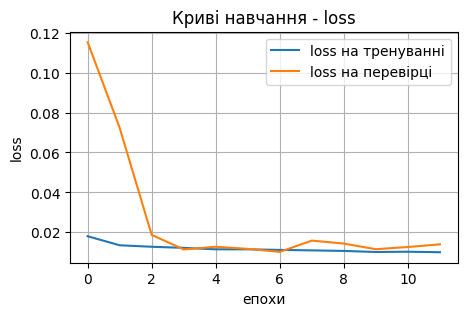

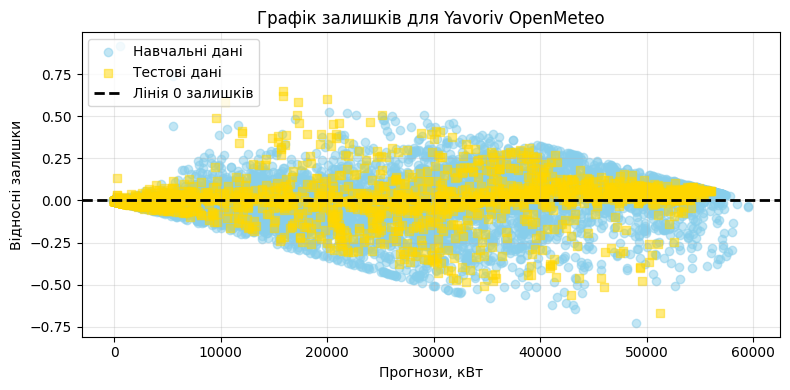

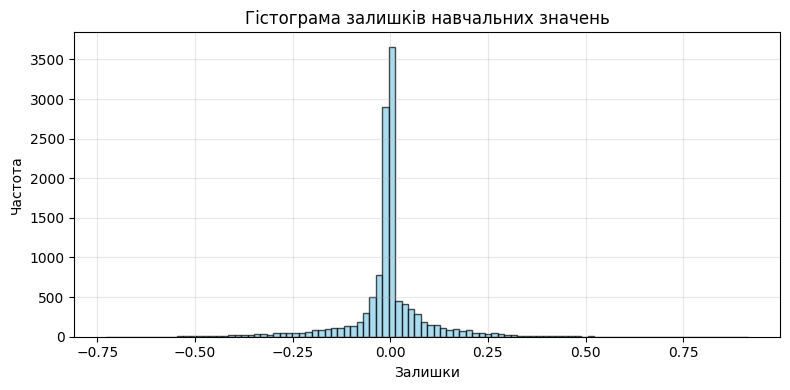

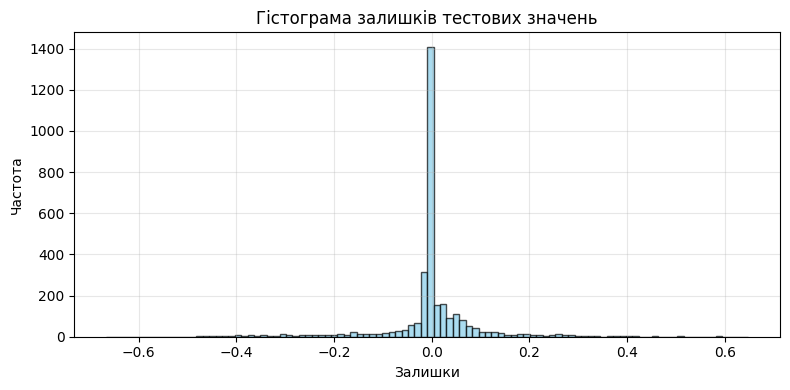

TAE: 8504890.039
MAE: 2756.853
MSE: 35753145.204
R2: 0.906
MSLE: 0.448
Bias: -0.240
APE: 28.338
MAPE: 682255526938325504.000
MAPE(max): 4.654
sMAPE: 35.845
RMSE: 5979.393
RMSE(max): 10.095
EV: 0.906
PCC: 0.952


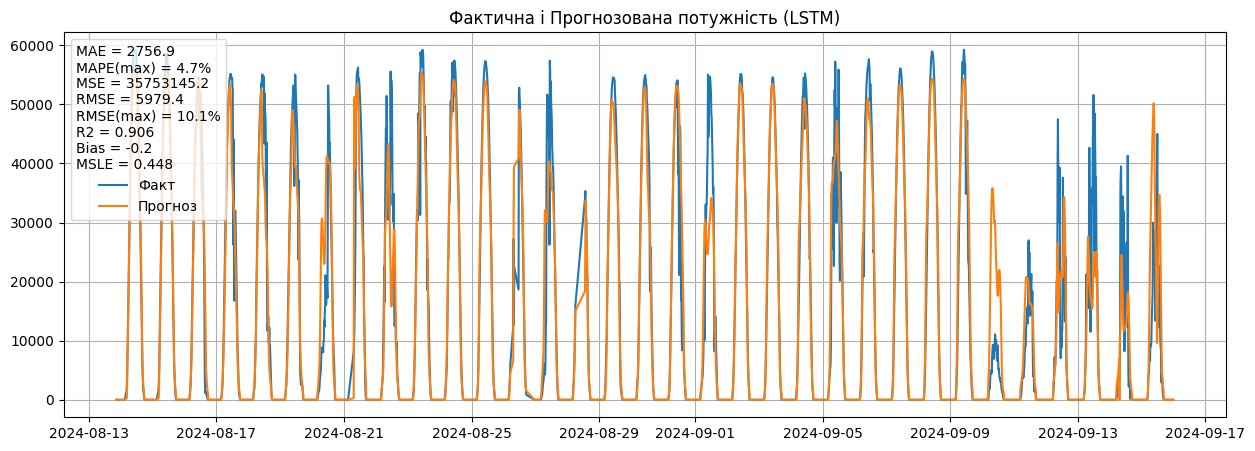

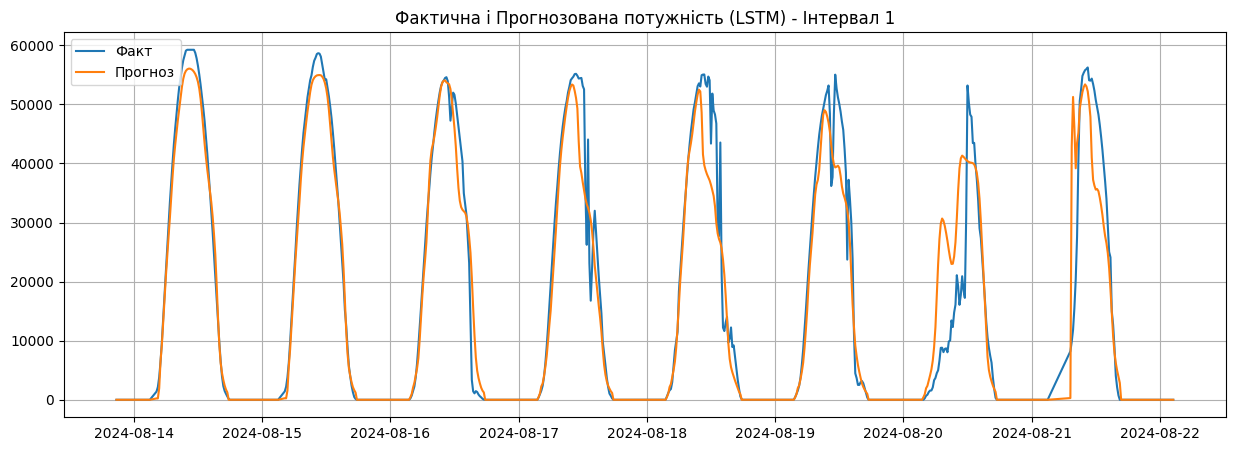

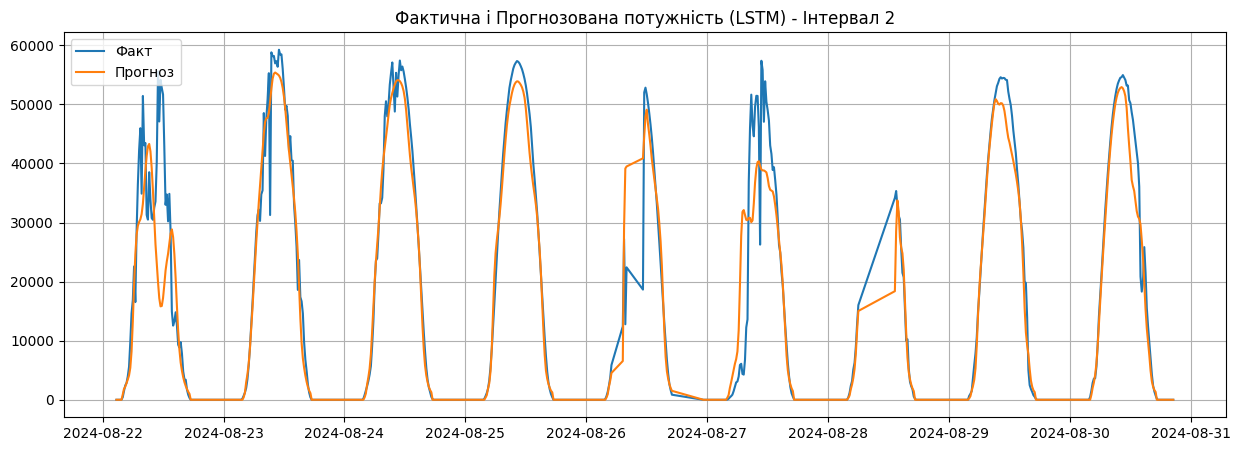

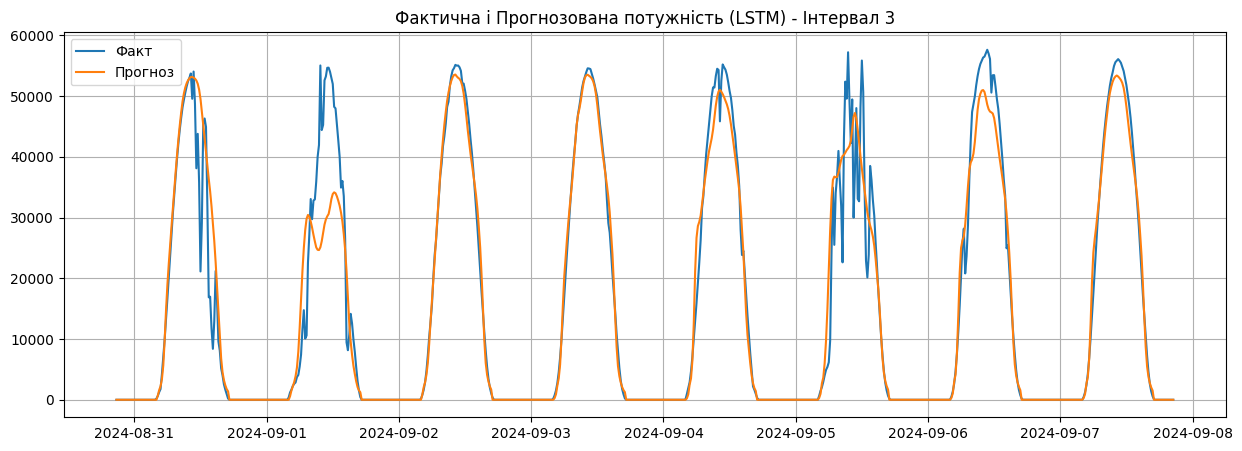

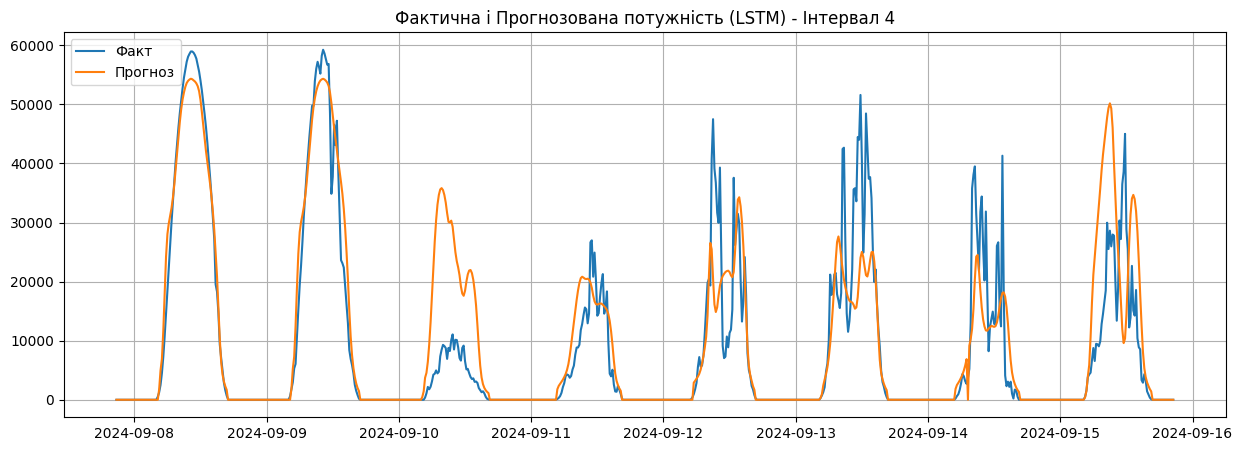

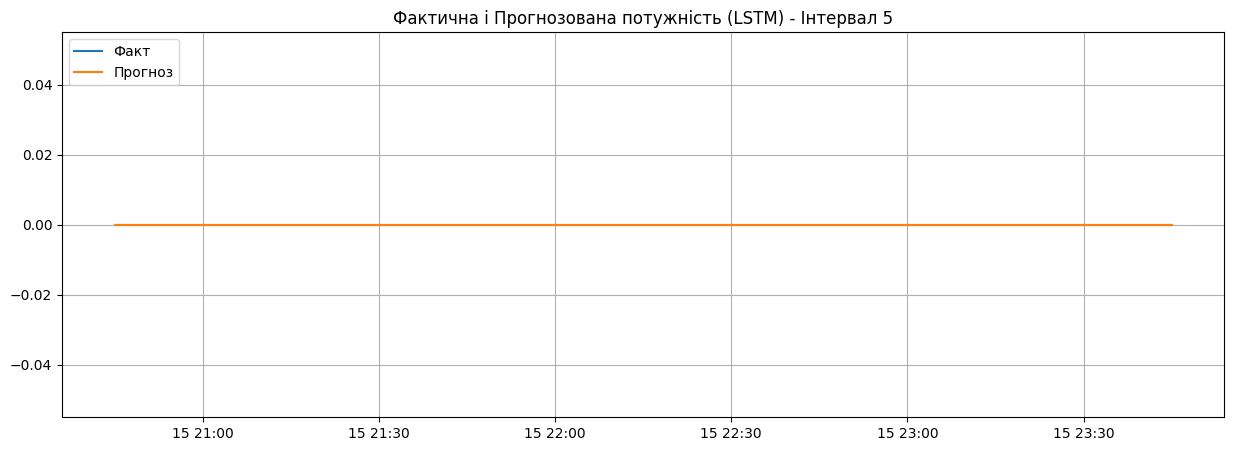



============= Glyniany-1 2024-04-02 - 2024-09-15 =============

Лінійна регресія:
TAE: 2564464.915
MAE: 165.610
MSE: 101503.694
R2: 0.875
MSLE: 0.506
Bias: 0.160
APE: 31.121
MAPE: 2175397398120558848.000
MAPE(max): 5.565
sMAPE: 43.402
RMSE: 318.596
RMSE(max): 10.706
EV: 0.875
PCC: 0.936

Розмір навчальної вибірки: 12384
Розмір тестової вибірки: 3093
Ознаки (19): ['forecast_0', 'gti', 'temperature_air', 'humidity', 'apparent_elevation', 'is_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'gti_lag_1', 'gti_lag_2', 'gti_lag_3', 'ghi_lag_1', 'ghi_lag_2', 'ghi_lag_3', 'dni_lag_1', 'dni_lag_2', 'dni_lag_3']
LSTM:

Epoch 1/32
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0245 - val_loss: 0.1066
Epoch 2/32
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0136 - val_loss: 0.0450
Epoch 3/32
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0118 - val_loss: 0.0122
Epoch 4/32
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0121 - val_loss: 0.0085
Epoch 5/32
194/194 ━━━━━━━━━

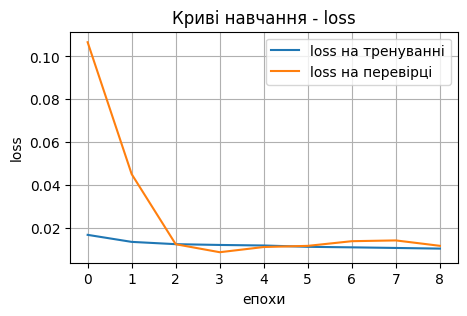

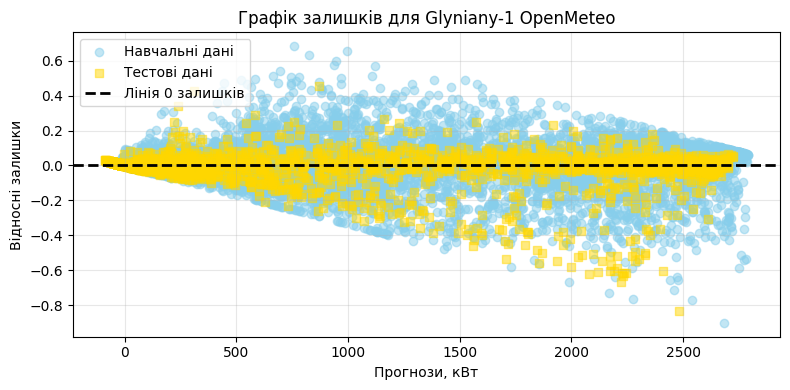

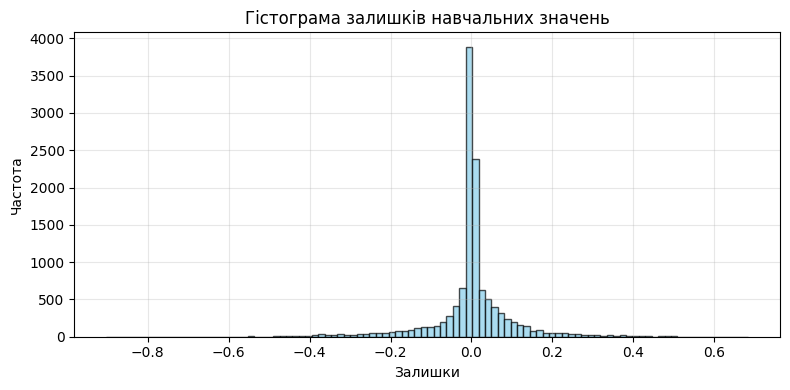

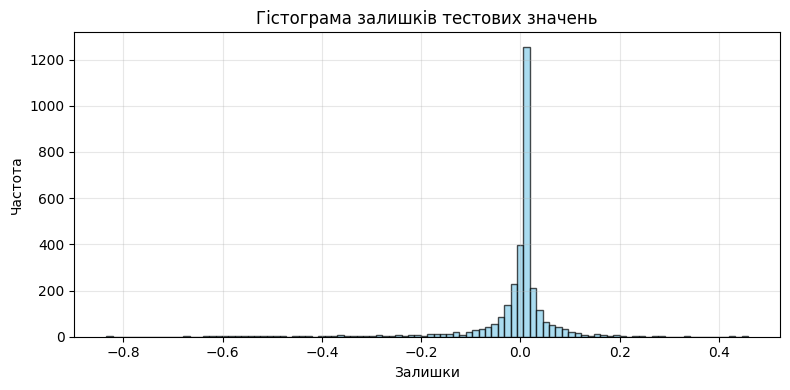

TAE: 347114.449
MAE: 112.226
MSE: 74555.806
R2: 0.912
MSLE: 0.285
Bias: 1.299
APE: 29.596
MAPE: 465267892014246720.000
MAPE(max): 3.771
sMAPE: 37.902
RMSE: 273.049
RMSE(max): 9.175
EV: 0.914
PCC: 0.958


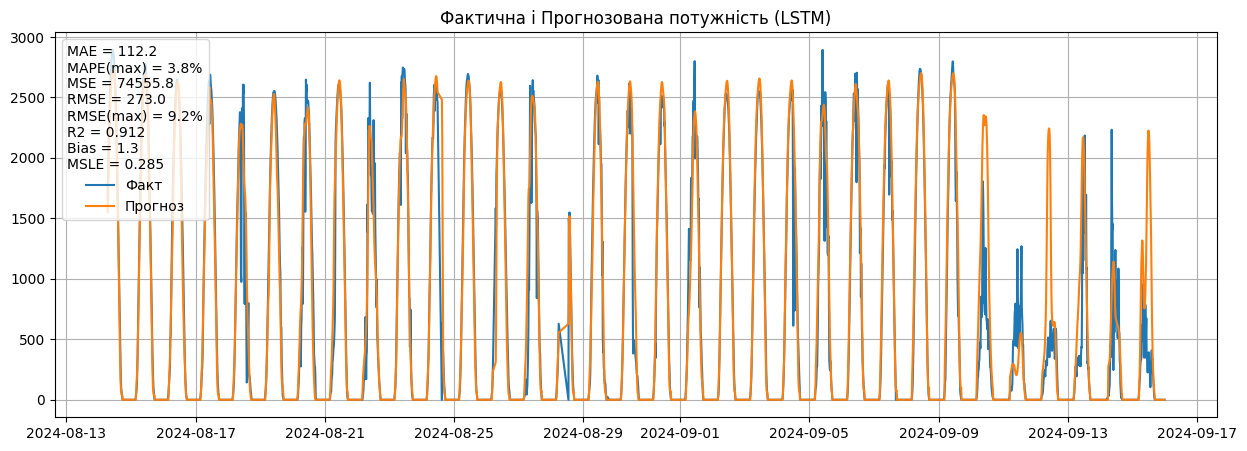

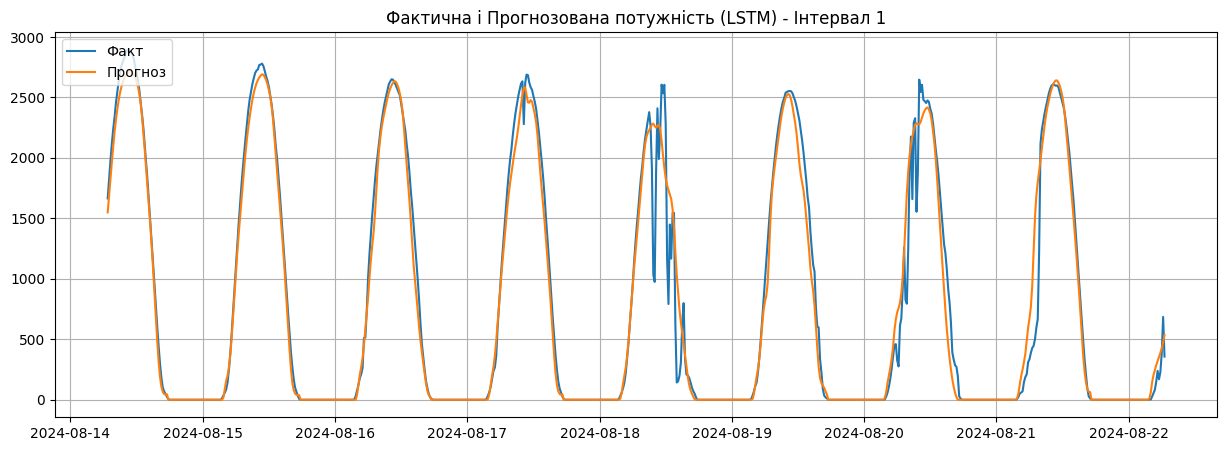

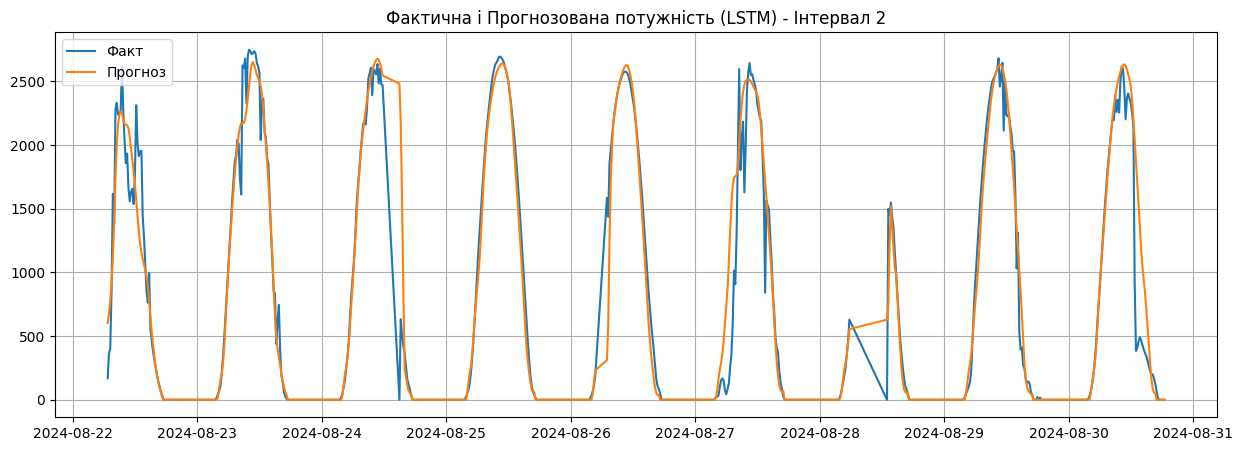

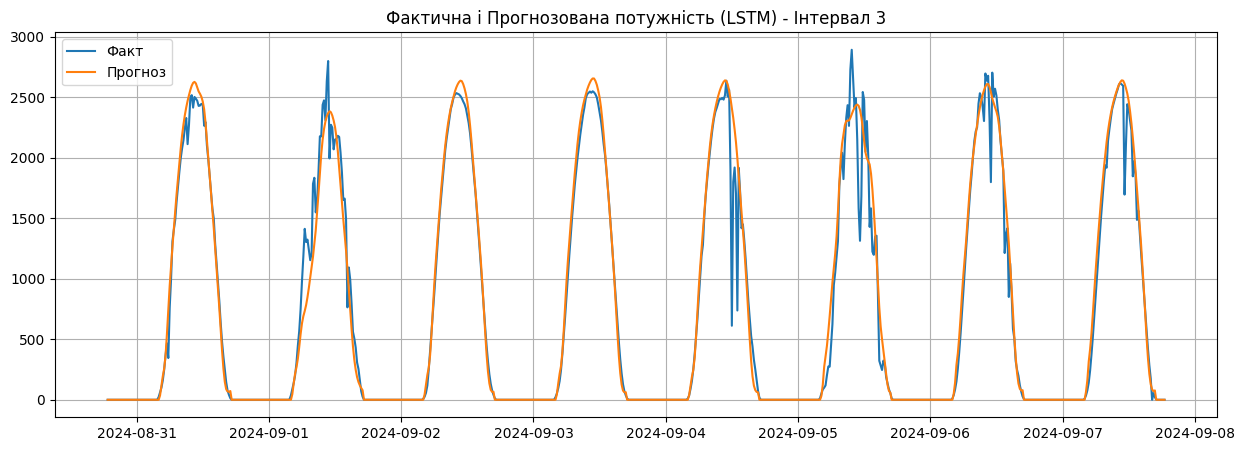

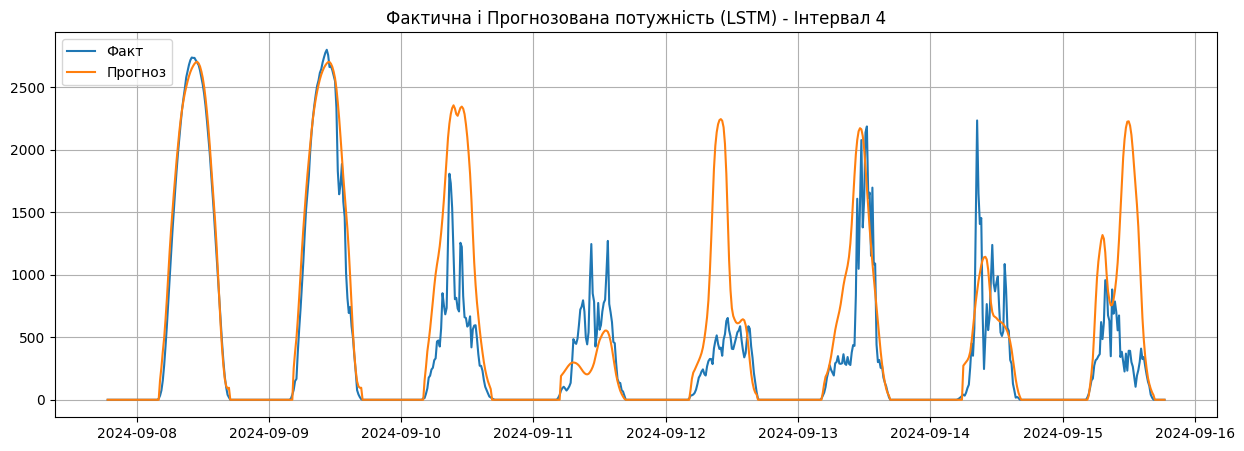

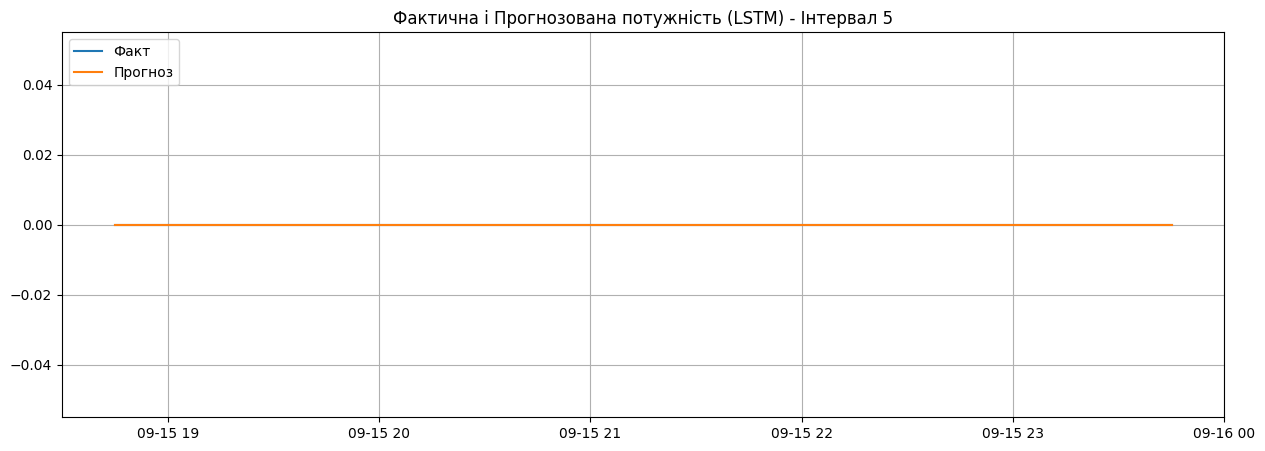



============= Glyniany-2 2024-04-02 - 2024-09-15 =============

Лінійна регресія:
TAE: 13728250.119
MAE: 890.462
MSE: 2878638.093
R2: 0.872
MSLE: 0.685
Bias: 0.179
APE: 32.529
MAPE: 8816178881784182784.000
MAPE(max): 5.766
sMAPE: 44.465
RMSE: 1696.655
RMSE(max): 10.987
EV: 0.872
PCC: 0.934

Розмір навчальної вибірки: 12329
Розмір тестової вибірки: 3080
Ознаки (19): ['forecast_0', 'gti', 'temperature_air', 'humidity', 'apparent_elevation', 'is_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'gti_lag_1', 'gti_lag_2', 'gti_lag_3', 'ghi_lag_1', 'ghi_lag_2', 'ghi_lag_3', 'dni_lag_1', 'dni_lag_2', 'dni_lag_3']
LSTM:

Epoch 1/32
193/193 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0244 - val_loss: 0.1380
Epoch 2/32
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0133 - val_loss: 0.0799
Epoch 3/32
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0128 - val_loss: 0.0144
Epoch 4/32
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0119 - val_loss: 0.0109
Epoch 5/32
193/193 ━━━━━━

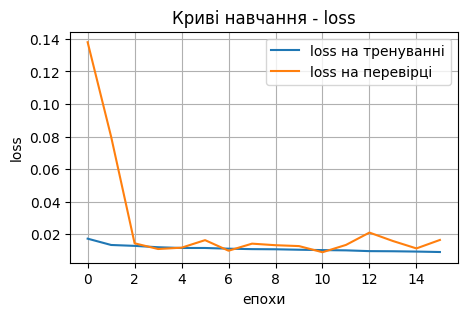

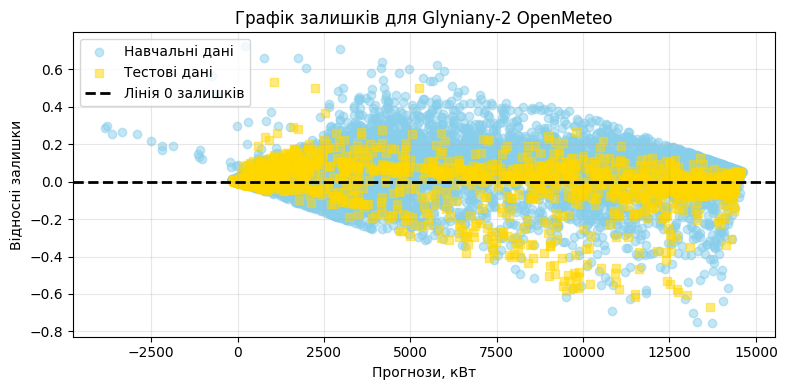

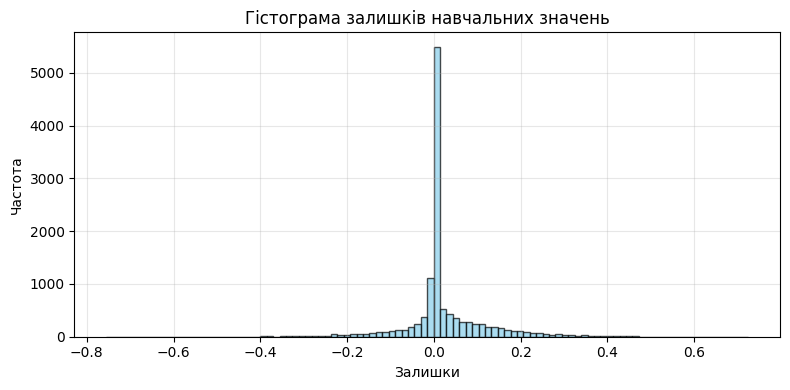

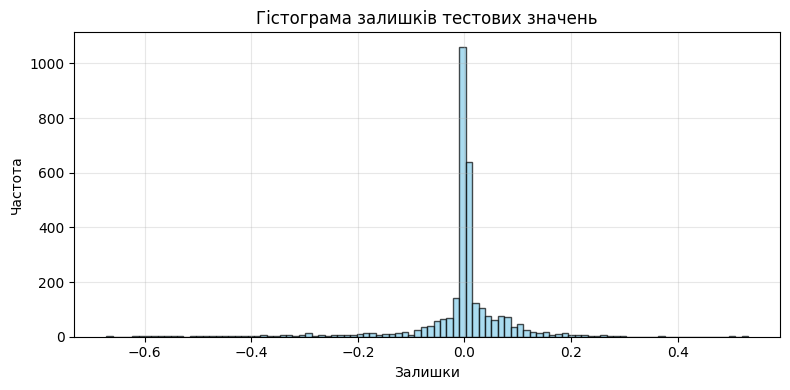

TAE: 2032398.693
MAE: 659.870
MSE: 2127548.126
R2: 0.916
MSLE: 0.391
Bias: 0.497
APE: 32.858
MAPE: 28.749
MAPE(max): 4.273
sMAPE: 40.838
RMSE: 1458.612
RMSE(max): 9.446
EV: 0.916
PCC: 0.959


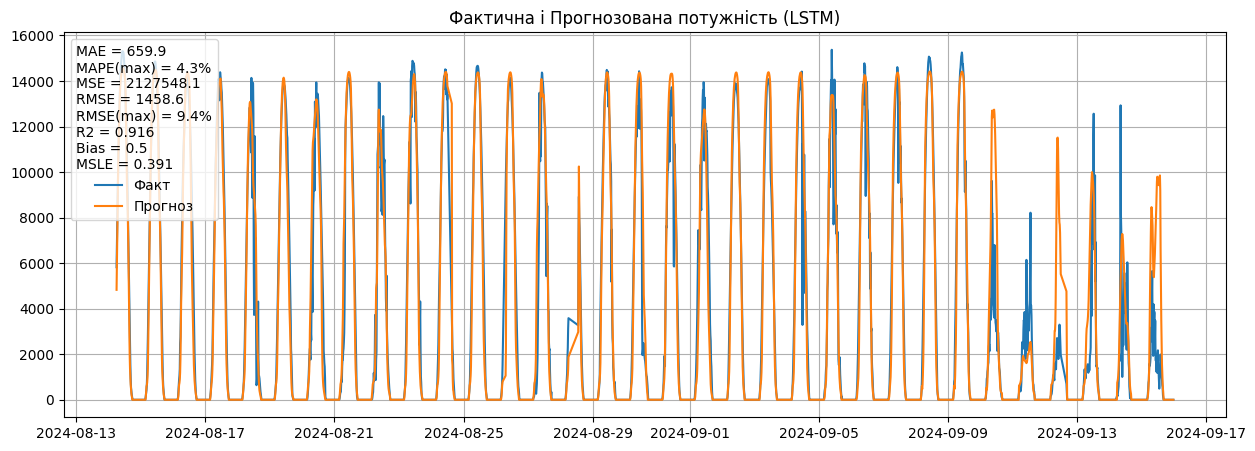

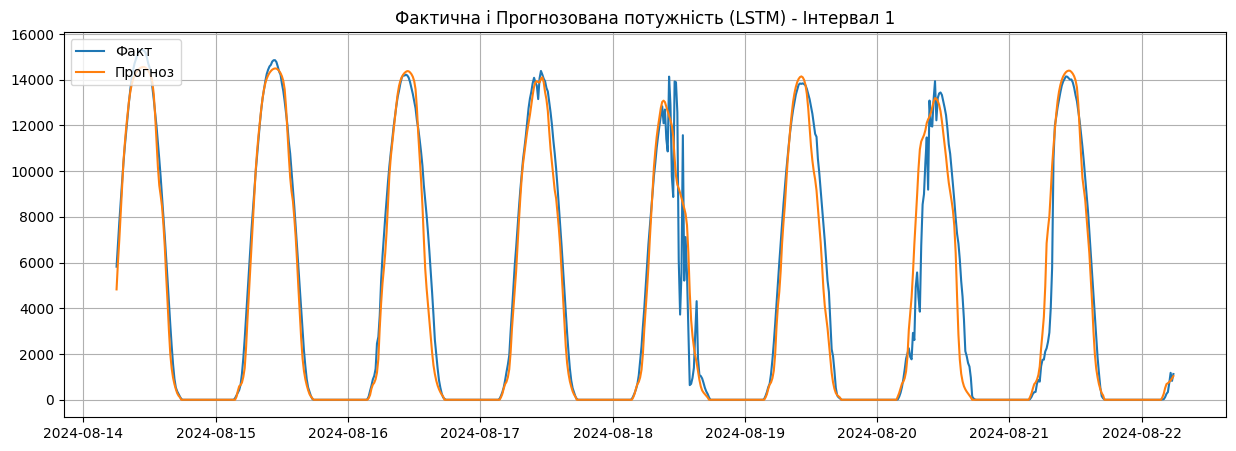

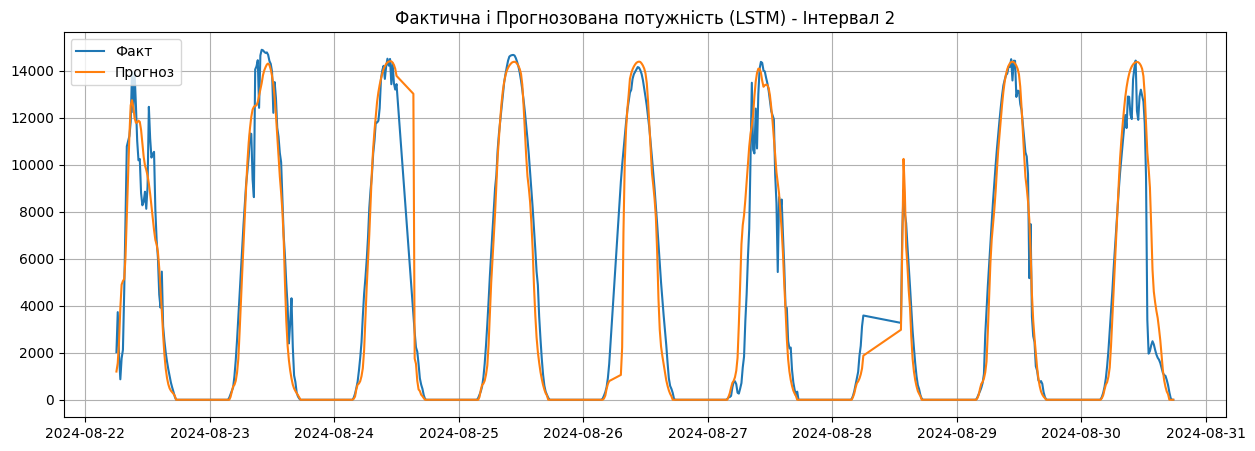

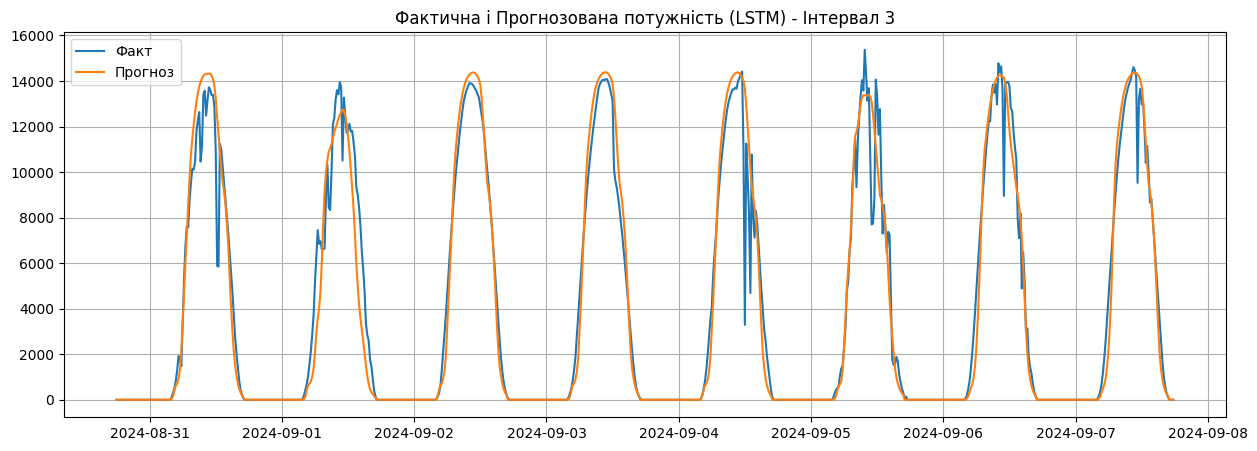

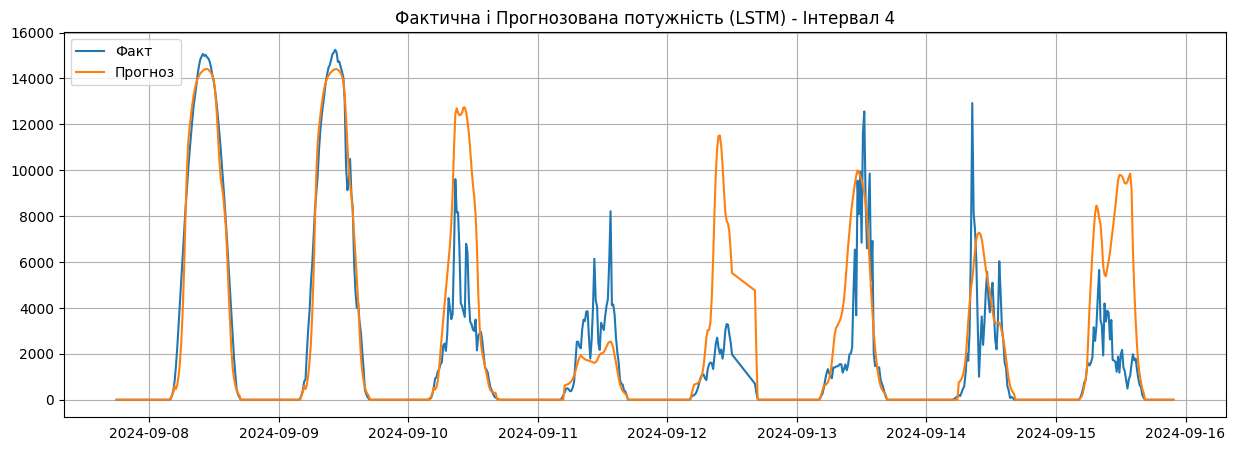

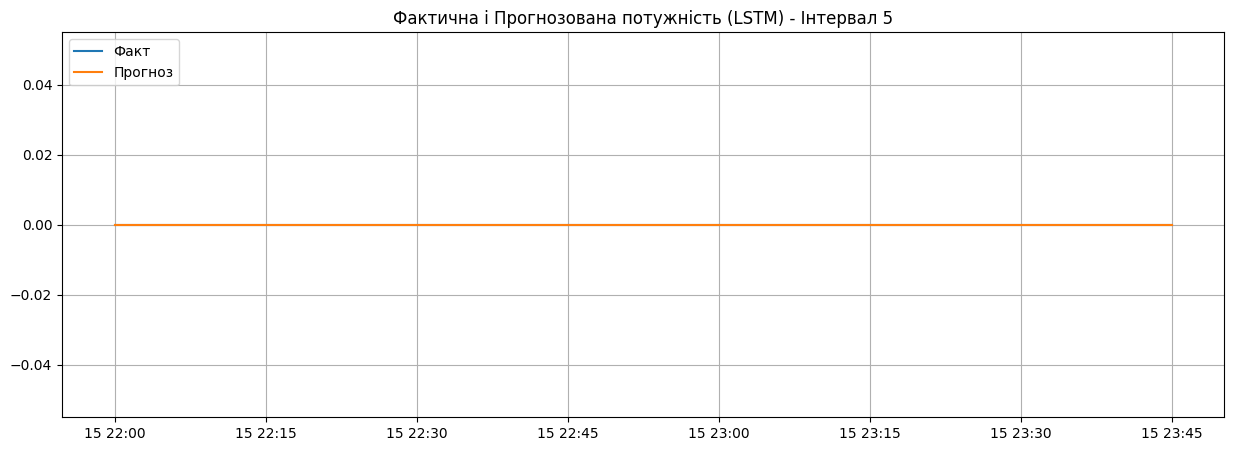



============= Boryslav 2024-04-02 - 2024-09-15 =============

Лінійна регресія:
TAE: 6824716.150
MAE: 440.503
MSE: 686385.544
R2: 0.851
MSLE: 0.515
Bias: 0.244
APE: 36.404
MAPE: 371492248504422720.000
MAPE(max): 6.158
sMAPE: 49.210
RMSE: 828.484
RMSE(max): 11.582
EV: 0.851
PCC: 0.923

Розмір навчальної вибірки: 12390
Розмір тестової вибірки: 3095
Ознаки (19): ['forecast_0', 'gti', 'temperature_air', 'humidity', 'apparent_elevation', 'is_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'gti_lag_1', 'gti_lag_2', 'gti_lag_3', 'ghi_lag_1', 'ghi_lag_2', 'ghi_lag_3', 'dni_lag_1', 'dni_lag_2', 'dni_lag_3']
LSTM:

Epoch 1/32
194/194 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.0250 - val_loss: 0.1051
Epoch 2/32
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0149 - val_loss: 0.0636
Epoch 3/32
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0150 - val_loss: 0.0222
Epoch 4/32
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0140 - val_loss: 0.0112
Epoch 5/32
194/194 ━━━━━━━━━━━━

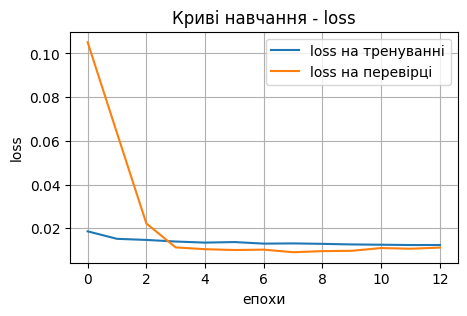

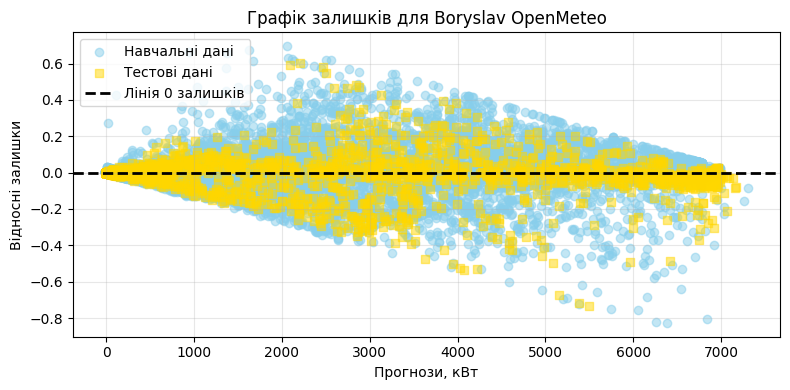

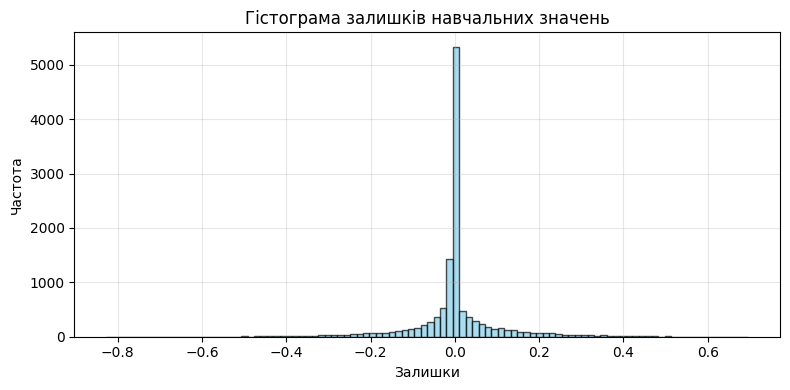

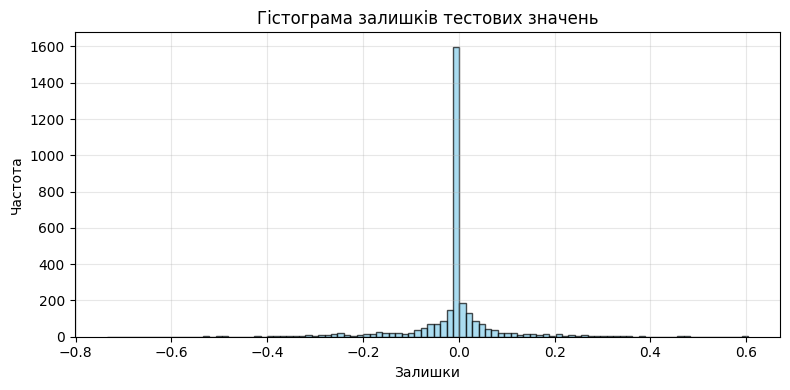

TAE: 975242.350
MAE: 315.103
MSE: 460882.072
R2: 0.909
MSLE: 0.351
Bias: 0.787
APE: 27.768
MAPE: 77172614206169776.000
MAPE(max): 4.405
sMAPE: 38.853
RMSE: 678.883
RMSE(max): 9.491
EV: 0.910
PCC: 0.955


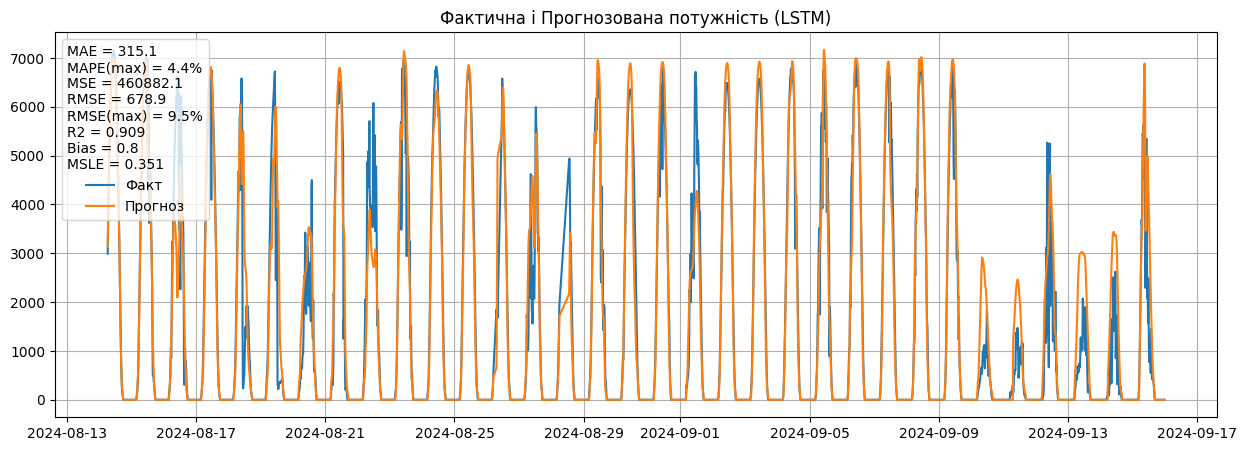

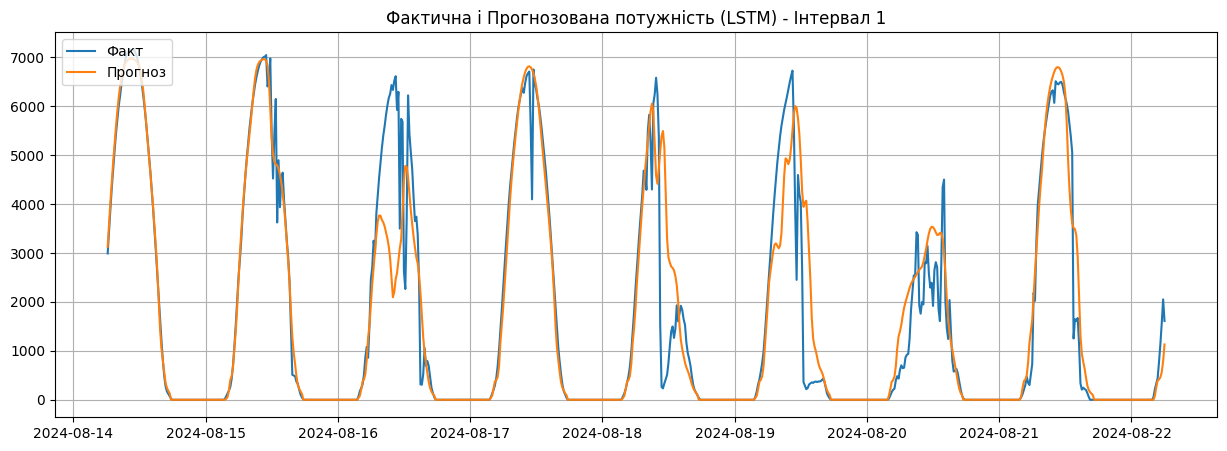

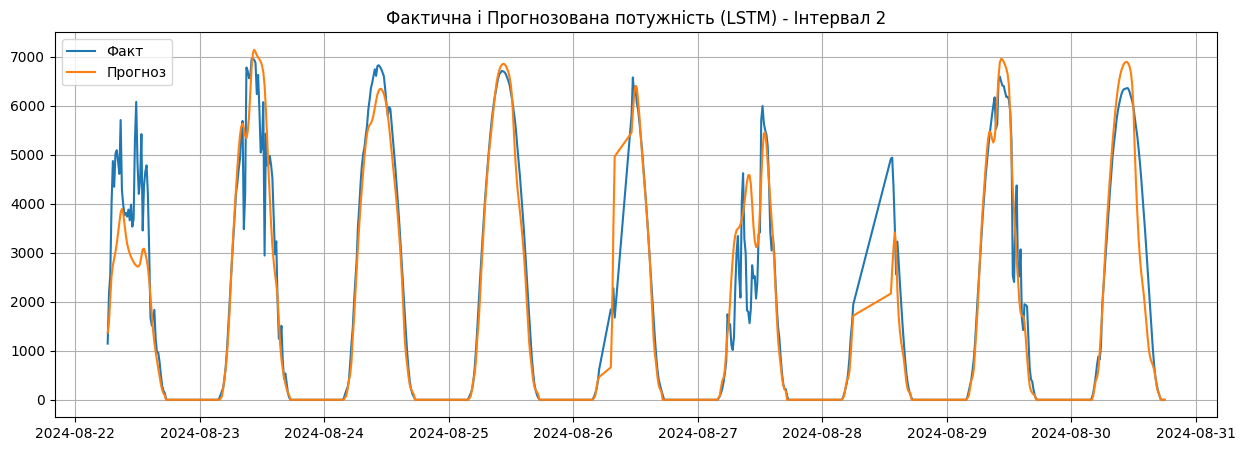

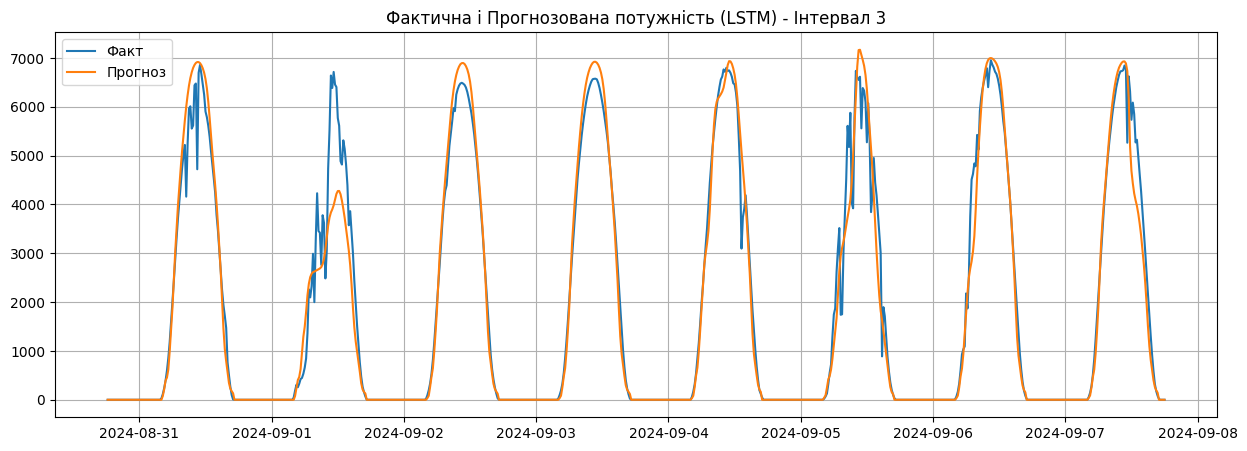

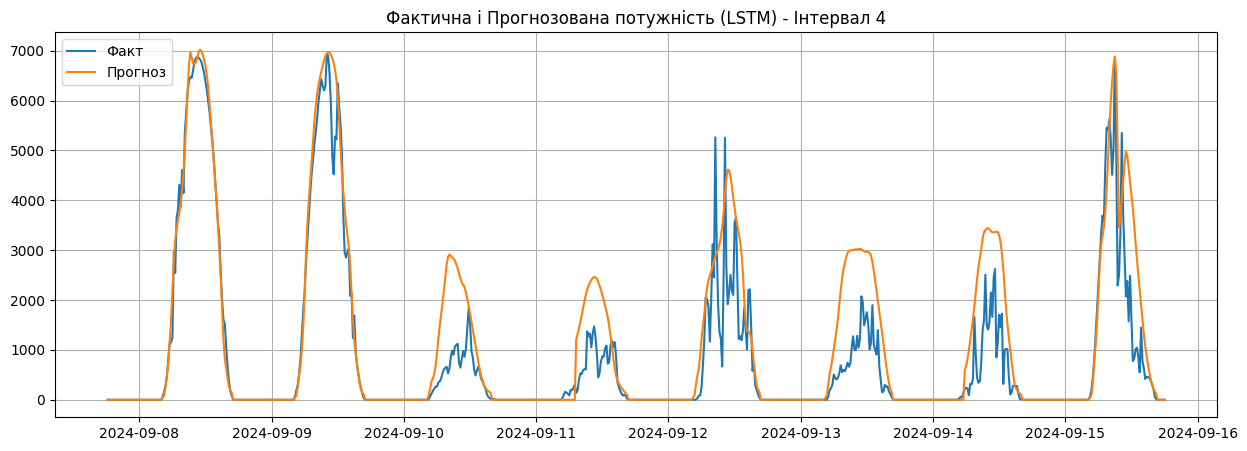

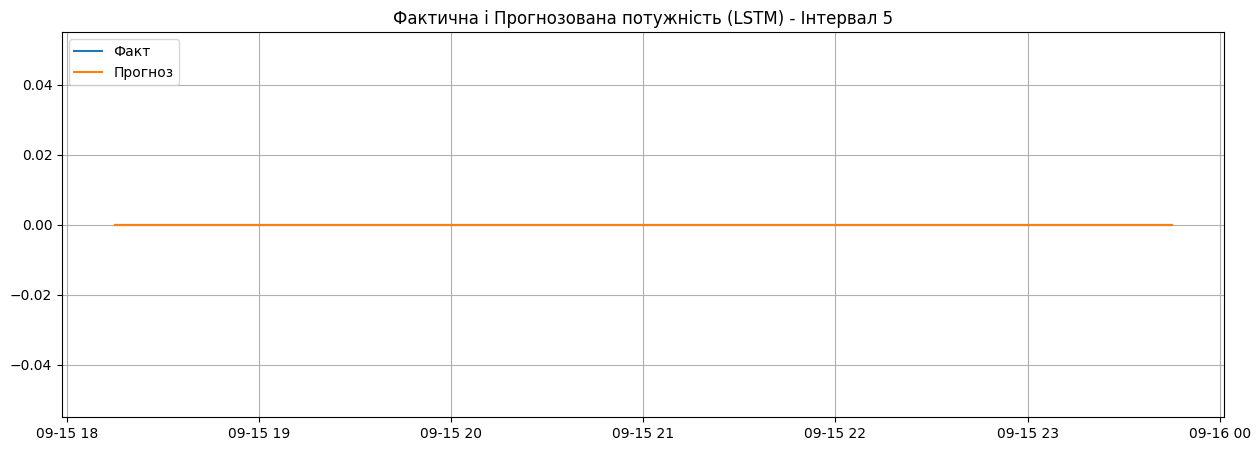



============= Radehiv-1 2024-04-02 - 2024-09-15 =============

Лінійна регресія:
TAE: 6326046.087
MAE: 410.223
MSE: 645726.038
R2: 0.867
MSLE: 1.545
Bias: 0.001
APE: 31.412
MAPE: 6628243180346175488.000
MAPE(max): 5.932
sMAPE: 101.707
RMSE: 803.571
RMSE(max): 11.621
EV: 0.867
PCC: 0.931

Розмір навчальної вибірки: 12332
Розмір тестової вибірки: 3081
Ознаки (19): ['forecast_0', 'gti', 'temperature_air', 'humidity', 'apparent_elevation', 'is_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'gti_lag_1', 'gti_lag_2', 'gti_lag_3', 'ghi_lag_1', 'ghi_lag_2', 'ghi_lag_3', 'dni_lag_1', 'dni_lag_2', 'dni_lag_3']
LSTM:

Epoch 1/32
193/193 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.0256 - val_loss: 0.1284
Epoch 2/32
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0163 - val_loss: 0.0696
Epoch 3/32
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0156 - val_loss: 0.0283
Epoch 4/32
193/193 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0149 - val_loss: 0.0095
Epoch 5/32
193/193 ━━━━━━━━━

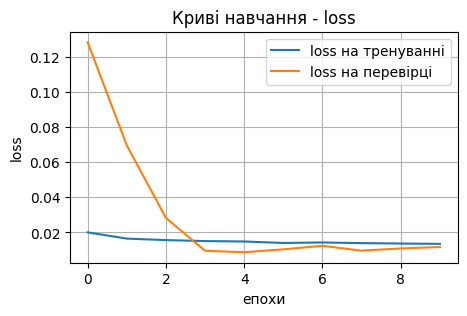

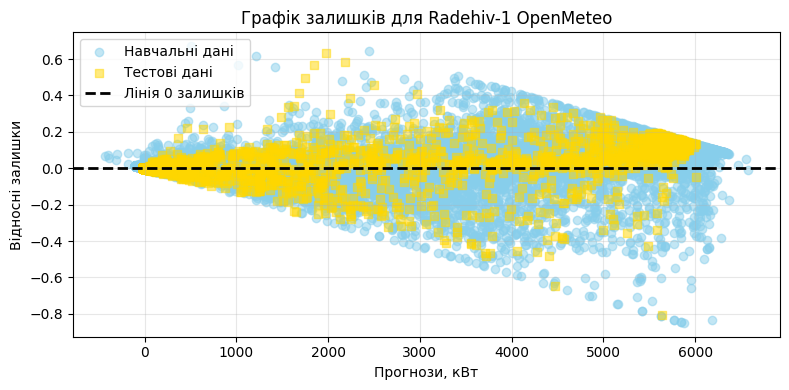

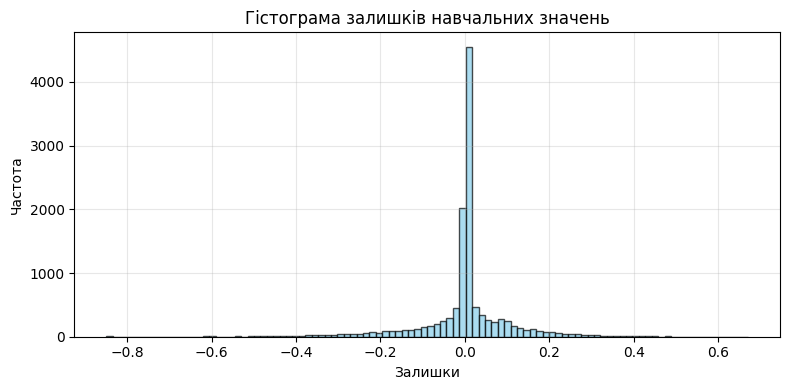

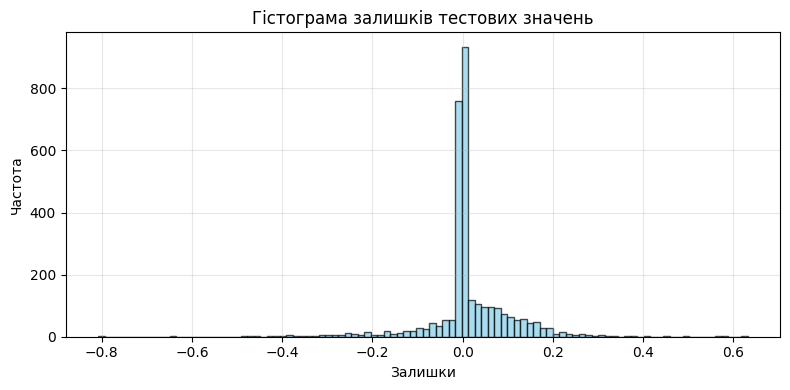

TAE: 1033376.826
MAE: 335.403
MSE: 408222.366
R2: 0.925
MSLE: 0.278
Bias: -1.422
APE: 27.173
MAPE: 167799463371190720.000
MAPE(max): 4.850
sMAPE: 37.182
RMSE: 638.923
RMSE(max): 9.240
EV: 0.926
PCC: 0.965


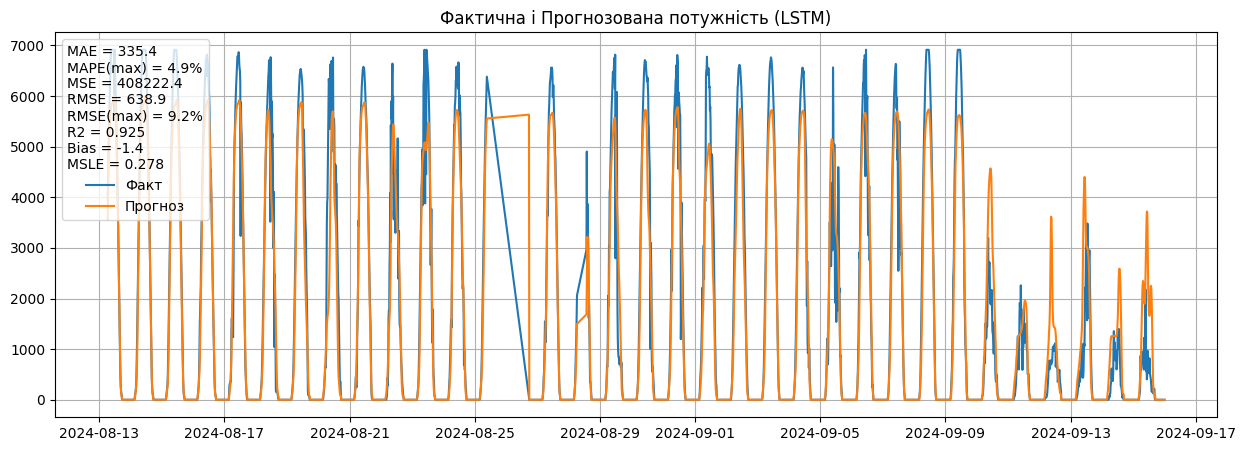

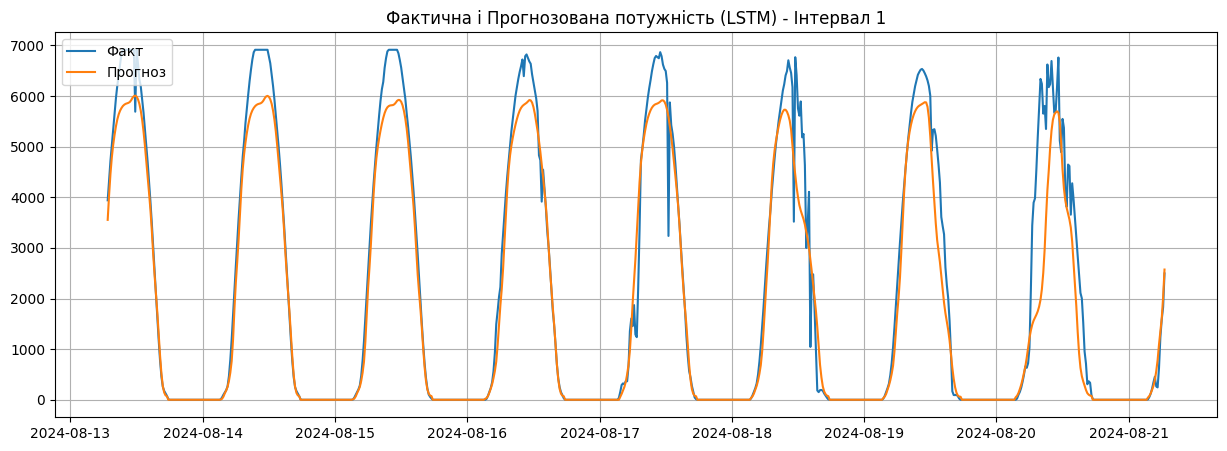

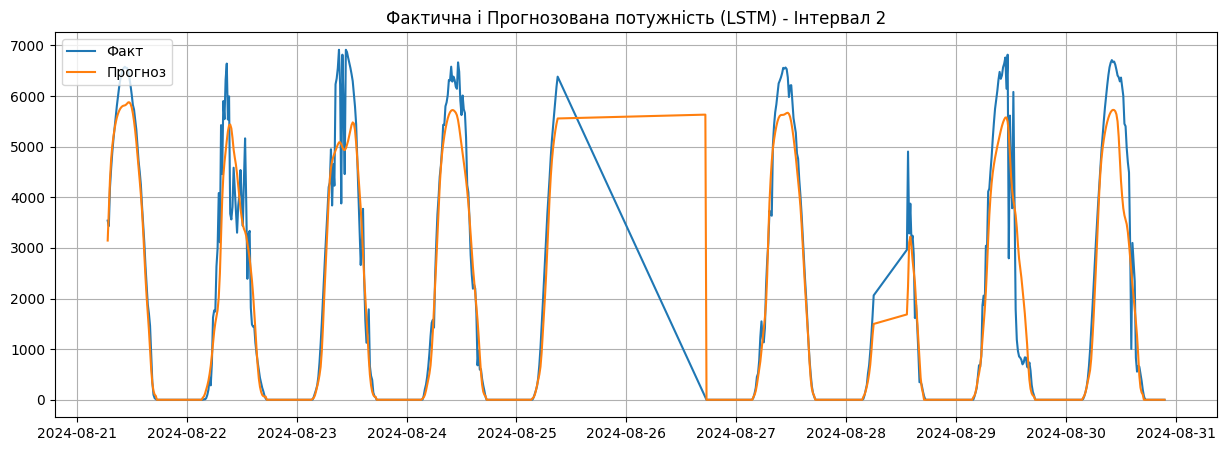

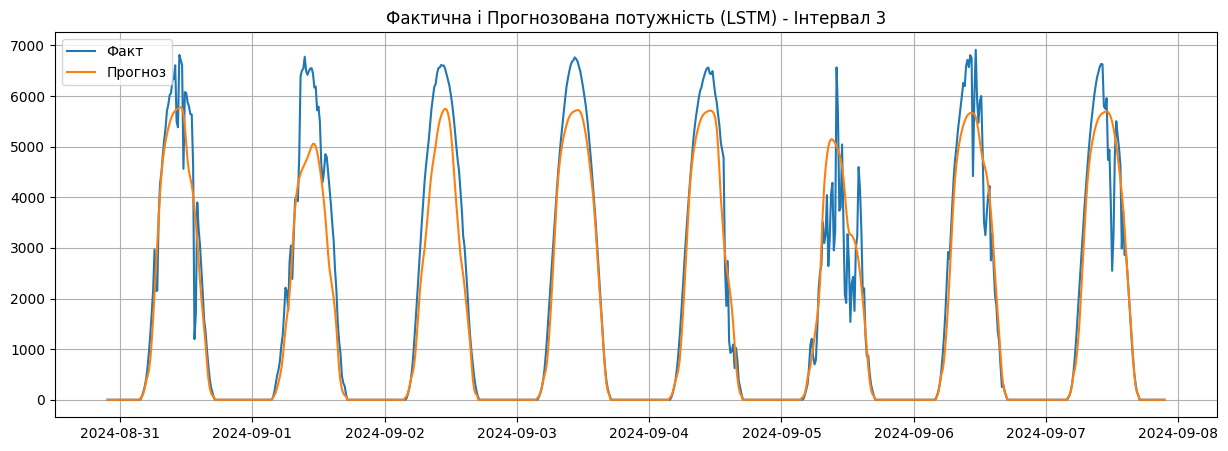

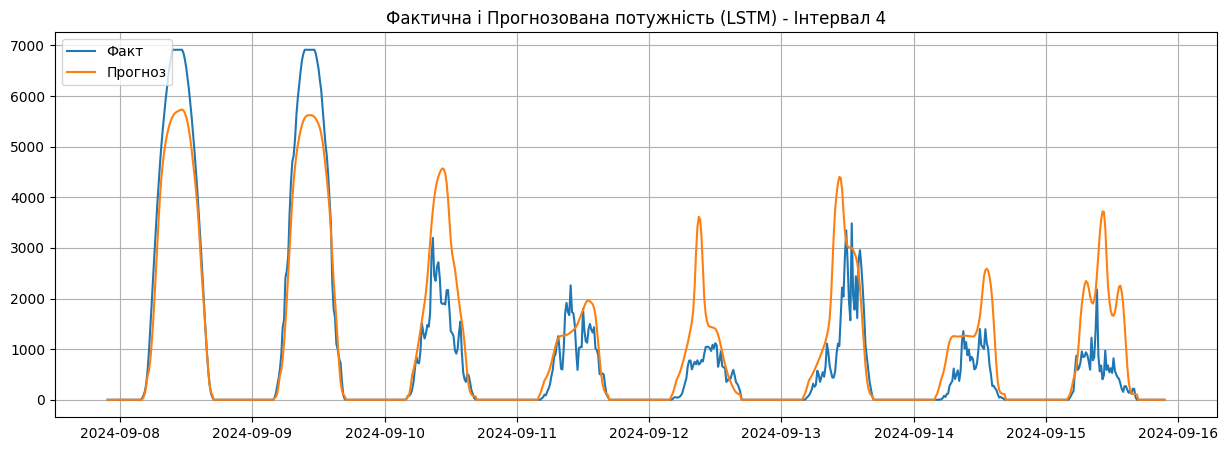

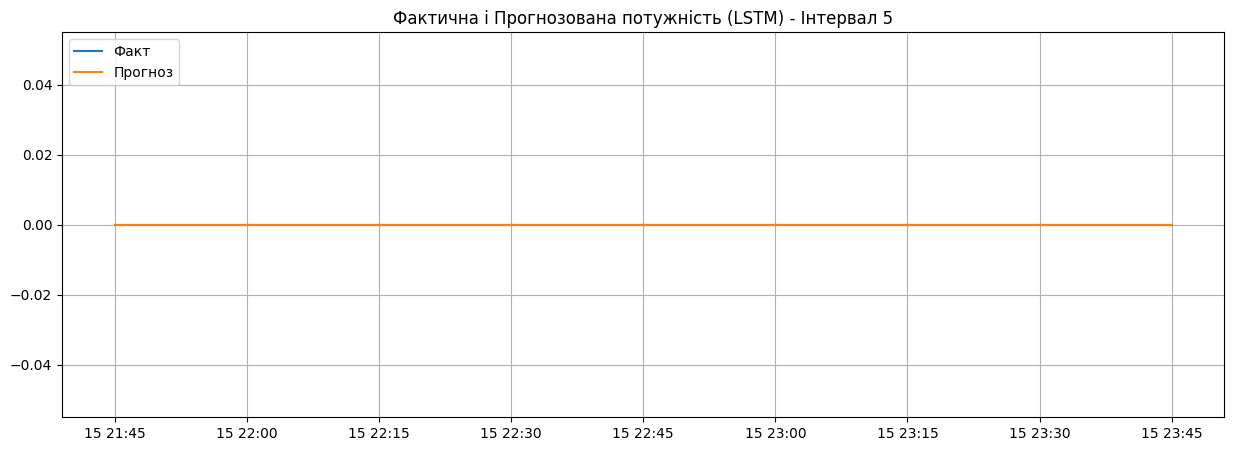



============= Boryslav 2024-04-02 - 2024-09-15 =============

Лінійна регресія:
TAE: 4859999.227
MAE: 313.690
MSE: 357491.746
R2: 0.923
MSLE: 0.483
Bias: 0.096
APE: 25.469
MAPE: 317523143443071232.000
MAPE(max): 4.385
sMAPE: 43.551
RMSE: 597.906
RMSE(max): 8.359
EV: 0.923
PCC: 0.961

Розмір навчальної вибірки: 12390
Розмір тестової вибірки: 3095
Ознаки (22): ['forecast_0', 'apparent_elevation', 'is_night', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'toa_lag_1', 'toa_lag_2', 'toa_lag_3', 'ghi_lag_1', 'ghi_lag_2', 'ghi_lag_3', 'bhi_lag_1', 'bhi_lag_2', 'bhi_lag_3', 'dhi_lag_1', 'dhi_lag_2', 'dhi_lag_3', 'bni_lag_1', 'bni_lag_2', 'bni_lag_3']
LSTM:

Epoch 1/32
194/194 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0218 - val_loss: 0.1025
Epoch 2/32
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0113 - val_loss: 0.0519
Epoch 3/32
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0091 - val_loss: 0.0071
Epoch 4/32
194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0094 - val_loss:

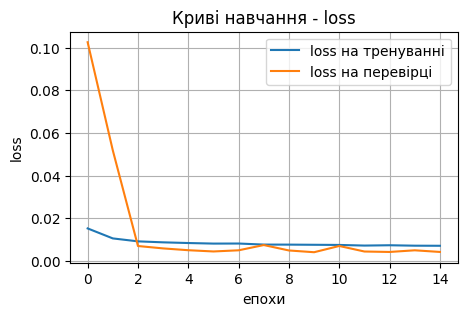

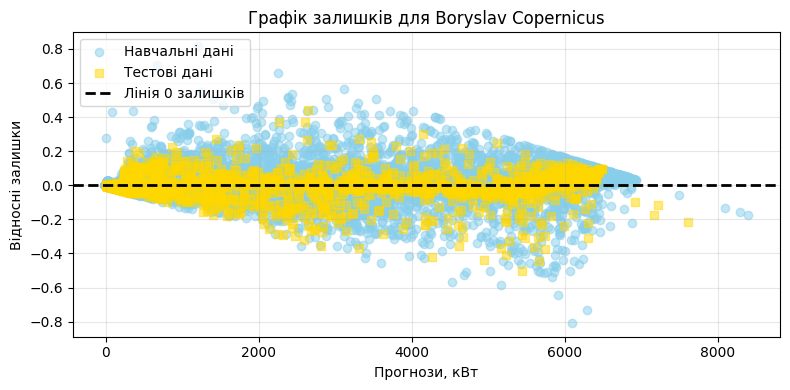

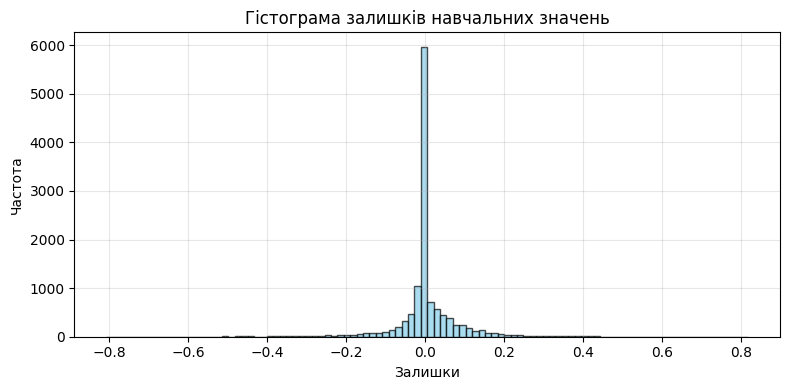

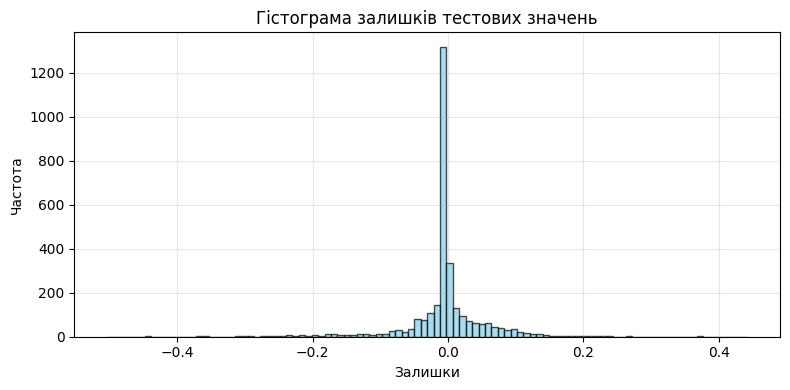

TAE: 695100.556
MAE: 224.588
MSE: 211910.354
R2: 0.958
MSLE: 0.415
Bias: 0.208
APE: 20.419
MAPE: 329240032146096960.000
MAPE(max): 3.140
sMAPE: 36.778
RMSE: 460.337
RMSE(max): 6.436
EV: 0.958
PCC: 0.979


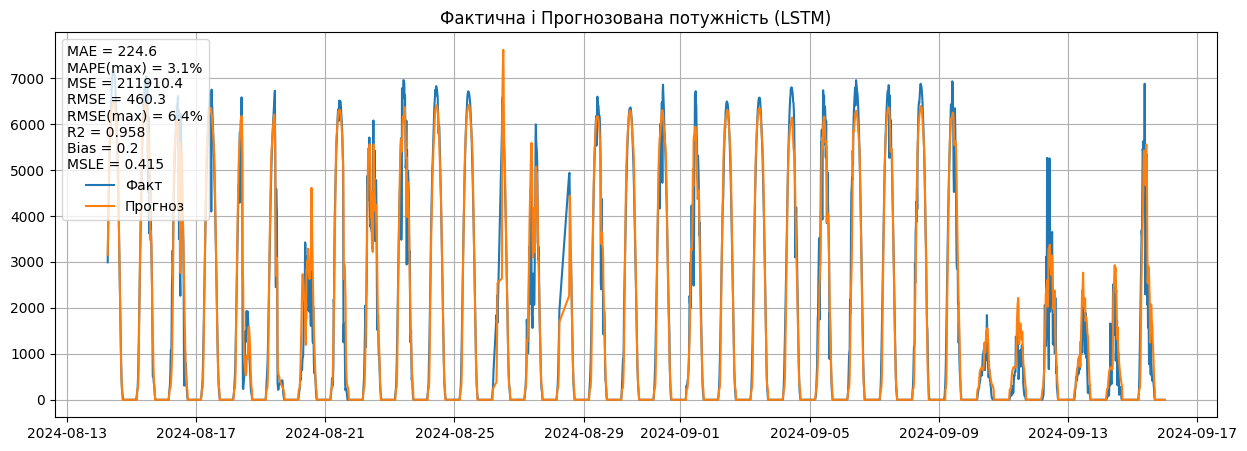

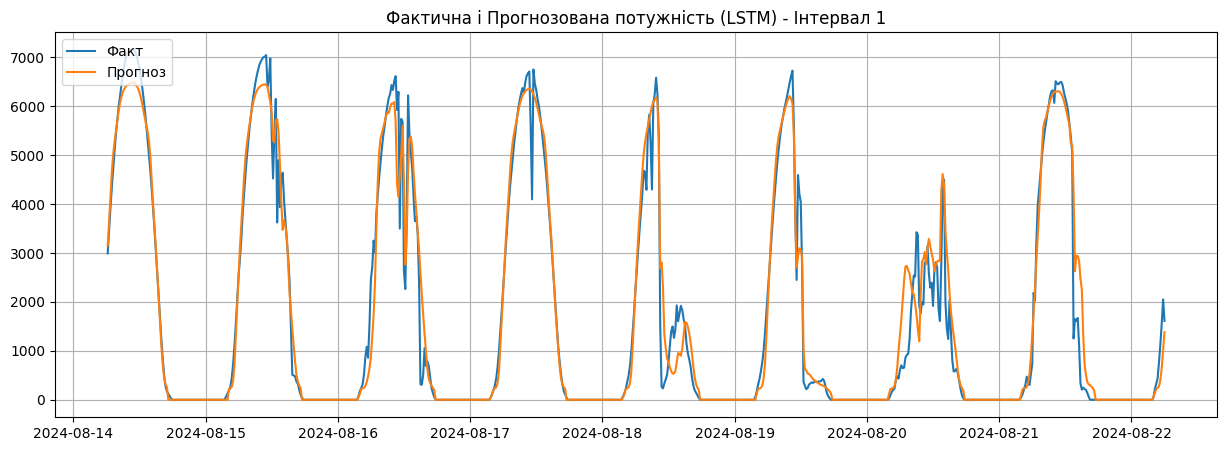

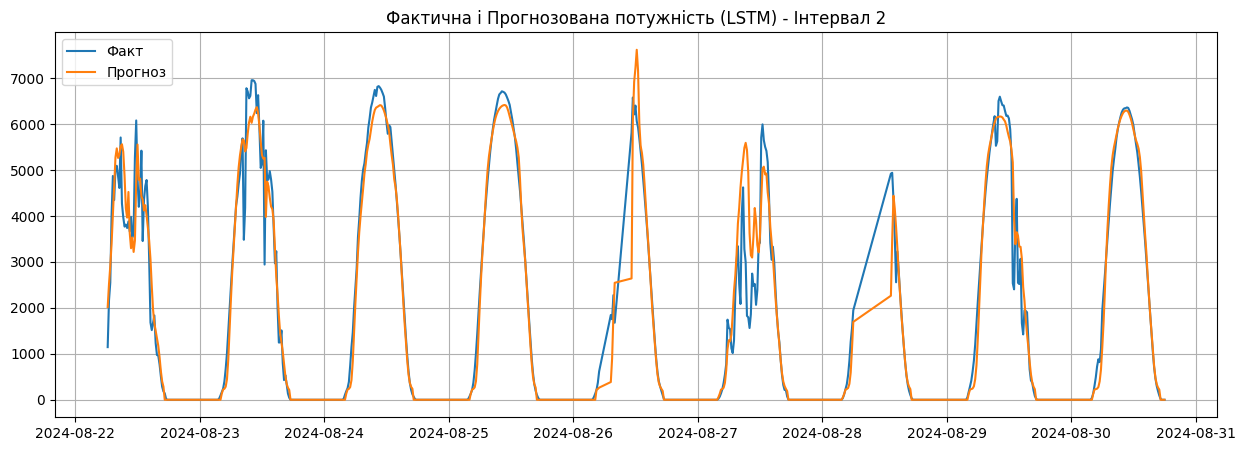

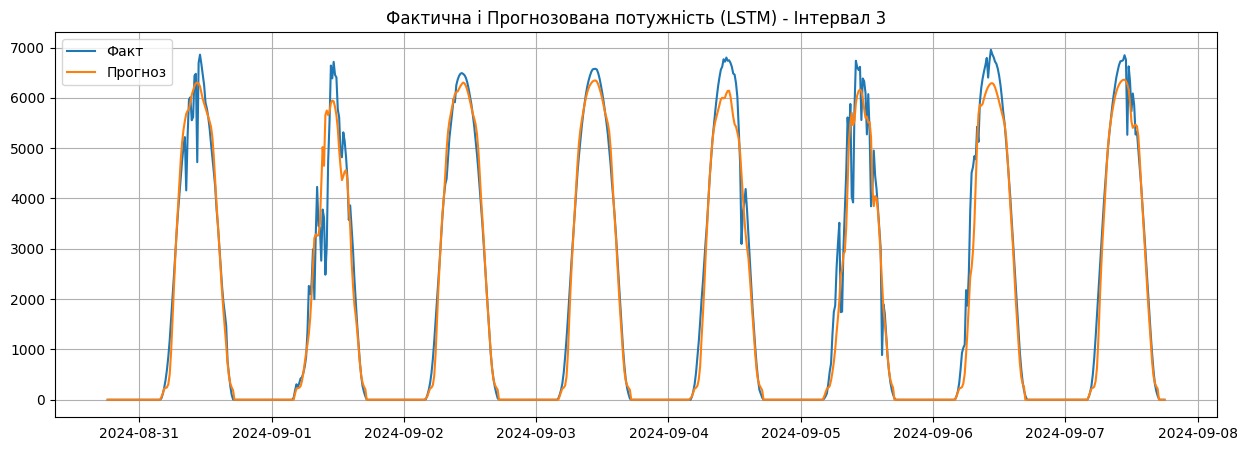

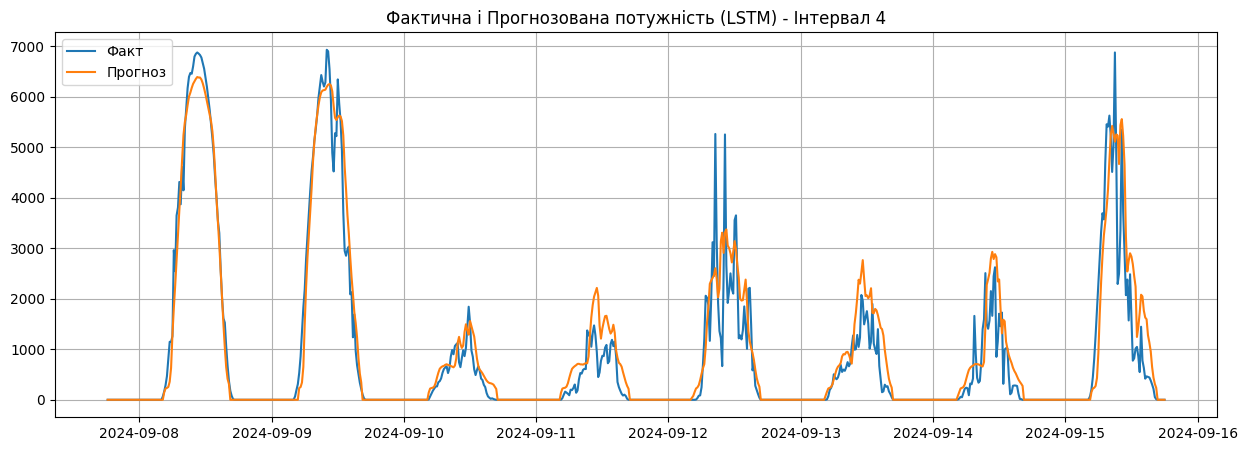

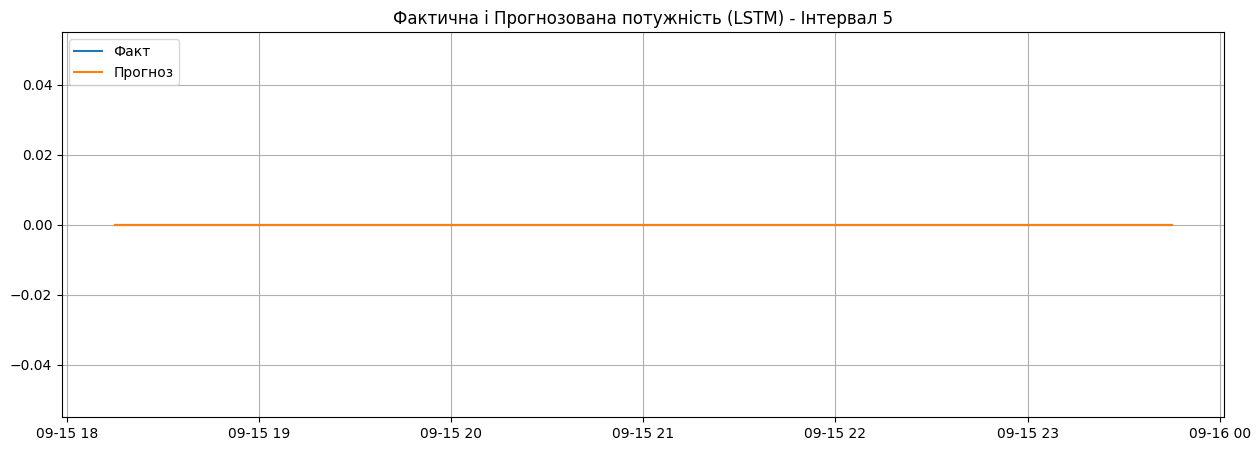

In [40]:
for model_ in models_list:
        model_name = f'lstm_{model_["station_name"]}{model_["meteo_source"]}'
        data = get_data(
                _station_name=model_["station_name"],
                _power_max=model_["power_max"],
                _date_start=model_["date_train_start"],
                _date_end=model_["date_train_end"],
                _meteo_source=model_["meteo_source"]
                )
        _power_max = model_["power_max"]

        print(f"\n\n============= {model_['station_name']} {model_['date_train_start']} - {model_['date_train_end']} =============")

        # Додавання ознак
        add_features(data,
                model_["latitude"], model_["longitude"], model_["altitude"],
                _meteo_source=model_["meteo_source"]
                )
        
        # Відображення метрик лінійної регресії
        print(f"\nЛінійна регресія:")
        evaluate_data(_forecast=data['forecast_0'], _actual=data['power'], _power_max=_power_max, _print_metrics=True)

        # Підготовка даних
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_train, X_test, y_train, y_test, datetimes_train, datetimes_test = prepare_data(_data=data,
                                                                                        _scaler=scaler,
                                                                                        _power_max=_power_max,
                                                                                        _split_ratio=0.8,
                                                                                        use_all_features = False)
        print(f"LSTM:\n")

        # Створення моделі
        model = create_model(X_train)

        # Тренування моделі
        history_train = do_train(model, X_train, X_test, y_train, y_test)

        plot_loss(_history=history_train, _title='Криві навчання', _metrics=['loss'])

        # Збереження моделі
        save_model(model, scaler, model_name)

        # Прогнозування
        y_train_pred = do_forecast(model, X_train)
        y_test_pred = do_forecast(model, X_test)

        # Відновлення даних та корекція прогнозу
        train_data_forecast = restore_data(_scaler=scaler,_forecast=y_train_pred,_X_test=X_train,_y_test=y_train,_datetimes_test=datetimes_train)
        test_data_forecast = restore_data(_scaler=scaler, _forecast=y_test_pred, _X_test=X_test, _y_test=y_test, _datetimes_test=datetimes_test)

        plot_residuals(
                _y_train_actual=train_data_forecast["power"],
                _y_train_forecast=train_data_forecast["forecast"],
                _y_test_actual=test_data_forecast["power"],
                _y_test_forecast=test_data_forecast["forecast"],
                _power_max=_power_max,
                _title=f"Графік залишків для {model_['station_name']} {model_['meteo_source']}"
        )
        
        plot_residual_histogram(_y_actual=train_data_forecast["power"],
                                _y_forecast=train_data_forecast["forecast"],
                                _power_max=_power_max,
                                _bins=100,
                                _title="Гістограма залишків навчальних значень")
        
        plot_residual_histogram(_y_actual=test_data_forecast["power"],
                                _y_forecast=test_data_forecast["forecast"],
                                _power_max=_power_max,
                                _bins=100,
                                _title="Гістограма залишків тестових значень")

        test_data_forecast = correct_forecast(test_data_forecast, data)

        # Оцінка прогнозу і візуалізація часовових рядів потужності
        model_['metrics'] = evaluate_data(_forecast=test_data_forecast['forecast'], _actual=test_data_forecast['power'], _power_max=_power_max, _print_metrics=True)
        plot_series(_data=test_data_forecast,
                _columns=  [{"column": "power", "label": "Факт", "power_max": model_["power_max"]},
                                {"column": "forecast", "label": "Прогноз", "power_max": model_["power_max"]}],
                _title="Фактична і Прогнозована потужність (LSTM)",
                _metrics=model_['metrics'],
                _split_days=8
                )

In [41]:
for model in models_list:
    model['metrics']['Станція (метеодані)'] = model.get('station_name', 'Unknown') + ' ' + model.get('meteo_source', 'Unknown')

# Вибір колонок для виводу
selected_columns = ["Станція (метеодані)", "MAPE(max)", "RMSE(max)", "R2", "MSLE", "Bias", "EV", "PCC"]

# Формування даних для таблиці
metrics_array = [
    {key: model['metrics'][key] for key in selected_columns if key in model['metrics']}
    for model in models_list
]

# Створення таблиці та округлення
metrics_table = pd.DataFrame(metrics_array)
metrics_table = metrics_table.round(2)
metrics_table.set_index('Станція (метеодані)', inplace=True)
# metrics_table['Рейтиг'] = metrics_table[['MAE', 'MAPE(max)', 'RMSE(max)']].sum(axis=1).rank(ascending=True)
# display(metrics_table.sort_values(by='Рейтиг'))

# Відображення таблиці
display(metrics_table)

MAPE(max)  RMSE(max)    R2  MSLE  Bias    EV   PCC
Станція (метеодані)                                                     
Yavoriv OpenMeteo          4.65      10.09  0.91  0.45 -0.24  0.91  0.95
Glyniany-1 OpenMeteo       3.77       9.18  0.91  0.29  1.30  0.91  0.96
Glyniany-2 OpenMeteo       4.27       9.45  0.92  0.39  0.50  0.92  0.96
Boryslav OpenMeteo         4.41       9.49  0.91  0.35  0.79  0.91  0.95
Radehiv-1 OpenMeteo        4.85       9.24  0.92  0.28 -1.42  0.93  0.97
Boryslav Copernicus        3.14       6.44  0.96  0.41  0.21  0.96  0.98